In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize
import shap

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### LightGBM

In [2]:
# classifier
def LightGBMC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


# regressor (optional)
def LightGBMR(train_x, test_x, train_y, test_y, config):
    
    reg = LGBMRegressor(**config)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


# classifier for all resampling datasets 
def runall_LightGBMC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
        
        result = LightGBMC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})
        
    return table_set
    
    
# regressor for all resampling datasets (optional)
def runall_LightGBMR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = LightGBMR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### Probability Calibration (optional)

In [ ]:
def stratified_data(train_data, cv):
    
    good = train_data[train_data.GB == 0]
    bad = train_data[train_data.GB == 1]
    good_index = random.sample(good.index.to_list(), k = len(good))
    bad_index = random.sample(bad.index.to_list(), k = len(bad))
    
    train_x_dict = {}
    train_y_dict = {}
    valid_x_dict = {}
    valid_y_dict = {}
    for i in range(cv):
        
        if (i+1) == cv:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))): ]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))): ]
        else:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))) : int(np.floor(((i+1)/cv)*len(good)))]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))) : int(np.floor(((i+1)/cv)*len(bad)))]
        good_train_index = [x for x in good_index if x not in good_valid_index]
        bad_train_index = [x for x in bad_index if x not in bad_valid_index]
        
        good_train = good.loc[good_train_index]
        good_valid = good.loc[good_valid_index]
        bad_train = bad.loc[bad_train_index]
        bad_valid = bad.loc[bad_valid_index]
        train = pd.concat([good_train, bad_train], axis = 0)
        valid = pd.concat([good_valid, bad_valid], axis = 0)
        train_x_dict[i], train_y_dict[i], valid_x_dict[i], valid_y_dict[i] = label_divide(train, valid, train_only = False)

    return train_x_dict, train_y_dict, valid_x_dict, valid_y_dict


def beta_map(s, a, b, c):
    return 1 / (1 + 1 / (np.power(np.exp(1), c)*(np.power(s, a) / np.power(1-s, b))))
                

def self_loss(three, test_y, predict_y):
    a, b, c = three
    new_s = beta_map(predict_y, a, b, c)
    loss = np.mean(test_y*np.log(new_s) + (1 - test_y)*np.log(1 - new_s))*(-1)
    return loss


def beta_LightGBMC(train_x, train_y, test_x, test_y, config, loss_function = self_loss):
    
    train = pd.concat([train_x, train_y], axis = 1)
    train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train, cv = 5)
    
    cali_param = {}
    for i in range(len(train_x_dict)):
        clf = LGBMClassifier(**config)
        clf.fit(train_x_dict[i], train_y_dict[i])
        predict_y = clf.predict_proba(valid_x_dict[i])[:, 1]
        mini_result = minimize(loss_function, [0.5, 0.5, 0.5], (valid_y_dict[i], predict_y))
        cali_param[i] = mini_result.x
        
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    
    cali_predict = np.array(0).astype(float)
    for i in range(len(cali_param)):
        cali_result = beta_map(predict_y, *cali_param[i])
        cali_predict = cali_predict + cali_result
    cali_predict /= len(cali_param)
      
    predict = (cali_predict > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})

    return result


def cali_LightGBMC(train_x, train_y, test_x, test_y, config, method):
    
    clf = LGBMClassifier(**config)
    cali_clf = CalibratedClassifierCV(clf, method = method, cv = 5)
    cali_clf.fit(train_x, train_y)
    predict_y = cali_clf.predict_proba(test_x)[:, 1]
    predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})
    
    return result 


def all_cali_LightGBMC(trainset_x, trainset_y, test_x, test_y, config_dict, method):
    
    keys = config_dict.keys()
    all_result = pd.DataFrame()
    for i in keys:
        print('\n', f'Data{i}:')
        
        if method in ['isotonic', 'sigmoid']:
            table = cali_LightGBMC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i], method)
        elif method == 'beta':
            table = beta_LightGBMC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i])
        result_df = cf_matrix(table, trainset_y[i])
        all_result = pd.concat([all_result, result_df], axis = 0).rename(index = {0: f'data{i}'})
        
    return all_result

### Optuna

In [3]:
# creator of optuna study for LightGBM
def LightGBM_creator(train_data, mode, num_valid = 5, label = 'GB') :

    def objective(trial) :
    
        param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 150, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = LightGBMC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = LightGBMR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

### Full Experiment

In [4]:
def full_lightgbm(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_LightGBM_{i}',
                                         creator = LightGBM_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = LightGBMC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## 

### For a Run

#### Load Data

In [5]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1368, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1369, 88)  balance ratio: 1.02
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2226, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

#### Search for The Best Hyperparameters

In [32]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 25,
                                     filename = 'runhist_array_m2m4_m5_3criteria_LightGBM',
                                     creator = LightGBM_creator
                                    )

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-03 16:26:03,965] A new study created in memory with name: no-name-39ee98ae-0032-4a1d-892b-a1589c108483


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
Precision: 0.9896507115135834 
Recall: 0.9973924380704041 
Aging Rate: 0.5039113428943938
[I 2022-03-03 16:26:11,184] Trial 0 finished with value: 0.9928457315158274 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.028232216848464952, 'reg_lambda': 0.03862528102485913}. Best is trial 0 with value: 0.9928457315158274.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:26:12,058] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.6583092753418394, 'reg_lambda': 0.10884642813348444}. Best is trial 0 with value: 0.9928457315158274.
Precision: 0.9025367156208278 
Recall: 0.8813559322033898 
Aging Rate: 0.48826597131681876
Precision: 0.8619824341279799 
Recall: 0.8956975228161669 
Aging Rate: 0.5195567144719687
Precision: 0.9109874826147427 
Recall: 0.8539765319426337 
Aging Rate: 0.46870925684485004
[I 2022-03-03 16:26:12,719] Trial 2 finished with value: 0.8839661475797578 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 

Precision: 0.8888888888888888 
Recall: 0.8761408083441982 
Aging Rate: 0.49282920469361147
Precision: 0.8899082568807339 
Recall: 0.8852672750977836 
Aging Rate: 0.4973924380704042
Precision: 0.9098250336473755 
Recall: 0.8813559322033898 
Aging Rate: 0.48435462842242505
[I 2022-03-03 16:26:22,765] Trial 14 finished with value: 0.88847158310438 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.12783685505694015, 'reg_lambda': 0.30679580237268034}. Best is trial 0 with value: 0.9928457315158274.
Precision: 0.9645669291338582 
Recall: 0.9582790091264668 
Aging Rate: 0.49674054758800523
Precision: 0.9535483870967741 
Recall: 0.9634941329856584 
Aging Rate: 0.5052151238591917
Precision: 0.961139896373057 
Recall: 0.9674054758800521 
Aging Rate: 0.5032594524119948
[I 2022-03-03 16:26:23,208] Trial 15 finished with value: 0.9613902188648454 an

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:26:24,521] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.08936898943441504, 'reg_lambda': 0.04398929917263658}. Best is trial 0 with value: 0.9928457315158274.
Precision: 0.9049479166666666 
Recall: 0.9061277705345502 
Aging Rate: 0.500651890482399
Precision: 0.9098039215686274 
Recall: 0.9074315514993481 
Aging Rate: 0.49869621903520206
Precision: 0.9146666666666666 
Recall: 0.894393741851369 
Aging Rate: 0.48891786179921776
[I 2022-03-03 16:26:25,008] Trial 18 finished with value: 0.9061900863355428 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:26:31,625] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.6763141693401693, 'reg_lambda': 0.0921885217604789}. Best is trial 0 with value: 0.9928457315158274.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:26:31,997] Trial 30 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 3.930053658411483, 'reg_lambda': 3.947649506029311}. Best is trial 0 with value: 0.9928457315158274.
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9818652849740933 
Recall: 0.9882659713168188 
Aging Rate: 0.5032594524119948
Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
[I 2022-03-03 16:26:32,685] Trial 31 finished with value: 0.990228212177202 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 

Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2022-03-03 16:26:43,174] Trial 43 finished with value: 0.9928236615913 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.44156715096471055, 'reg_lambda': 0.024477618706189627}. Best is trial 0 with value: 0.9928457315158274.
Precision: 0.9269588313413014 
Recall: 0.910039113428944 
Aging Rate: 0.4908735332464146
Precision: 0.9204244031830239 
Recall: 0.9048239895697523 
Aging Rate: 0.4915254237288136
Precision: 0.9152542372881356 
Recall: 0.9152542372881356 
Aging Rate: 0.5
[I 2022-03-03 16:26:43,861] Trial 44 finished with value: 0.9154109392872859 and parameters: {'n_estimators': 300,

Precision: 0.9641485275288092 
Recall: 0.9817470664928292 
Aging Rate: 0.5091264667535854
Precision: 0.9645203679369251 
Recall: 0.9569752281616688 
Aging Rate: 0.49608865710560623
Precision: 0.9661898569570871 
Recall: 0.9687092568448501 
Aging Rate: 0.5013037809647979
[I 2022-03-03 16:26:52,797] Trial 56 finished with value: 0.9670163726713746 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.12262701830969332, 'reg_lambda': 0.1296646068701469}. Best is trial 53 with value: 0.9932743786318842.
Precision: 0.904891304347826 
Recall: 0.8683181225554107 
Aging Rate: 0.47979139504563234
Precision: 0.907103825136612 
Recall: 0.8657105606258149 
Aging Rate: 0.4771838331160365
Precision: 0.9018324607329843 
Recall: 0.8983050847457628 
Aging Rate: 0.4980443285528031
[I 2022-03-03 16:26:53,461] Trial 57 finished with value: 0.890738936998709 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:27:01,427] Trial 64 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.0240799926163405, 'reg_lambda': 0.10662910212793177}. Best is trial 63 with value: 0.9956546263728564.
Precision: 0.9493029150823827 
Recall: 0.9765319426336375 
Aging Rate: 0.5143415906127771
Precision: 0.961340206185567 
Recall: 0.9726205997392438 
Aging Rate: 0.5058670143415906
Precision: 0.961340206185567 
Recall: 0.9726205997392438 
Aging Rate: 0.5058670143415906
[I 2022-03-03 16:27:02,028] Trial 65 finished with value: 0.9655399818179898 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytr

Precision: 0.9616368286445013 
Recall: 0.9804432855280313 
Aging Rate: 0.5097783572359843
Precision: 0.950381679389313 
Recall: 0.9739243807040417 
Aging Rate: 0.5123859191655802
Precision: 0.9565772669220945 
Recall: 0.9765319426336375 
Aging Rate: 0.5104302477183833
[I 2022-03-03 16:27:16,848] Trial 77 finished with value: 0.9664698756892309 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.01039966845357403, 'reg_lambda': 0.0985219954534706}. Best is trial 63 with value: 0.9956546263728564.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:27:17,215] Trial 78 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.020857114110230043, 'reg_lambda': 0.1498454452757906}. Best is trial 63 with value: 0.9956546263728564.
Precision: 0.9921465968586387 
Recall: 0.9882659713168188 
Aging Rate: 0.4980443285528031
Precision: 0.9909443725743855 
Recall: 0.9986962190352021 
Aging Rate: 0.5039113428943938
Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
[I 2022-03-03 16:27:19,667] Trial 79 finished with value: 0.9921868777694384 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_by

Precision: 0.9844357976653697 
Recall: 0.9895697522816167 
Aging Rate: 0.5026075619295959
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
Precision: 0.9870633893919794 
Recall: 0.9947848761408083 
Aging Rate: 0.5039113428943938
[I 2022-03-03 16:27:38,458] Trial 91 finished with value: 0.9895929076617183 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.2361568555380844, 'reg_lambda': 0.15904443256156786}. Best is trial 63 with value: 0.9956546263728564.
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9832904884318766 
Recall: 0.9973924380704041 
Aging Rate: 0.5071707953063885
Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
[I 2022-03-03 16:27:39,880] Trial 92 finished with value: 0.9919798197132029 and parameters: {'n_estimators'

[I 2022-03-03 16:27:52,878] A new study created in memory with name: no-name-d50854fd-268a-478b-8feb-d85f070a1904


Precision: 0.8706666666666667 
Recall: 0.8513689700130378 
Aging Rate: 0.48891786179921776
[I 2022-03-03 16:27:52,706] Trial 99 finished with value: 0.867700793735961 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.5498213998312477, 'reg_lambda': 0.029849872615924318}. Best is trial 63 with value: 0.9956546263728564.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.8159675236806495 
Recall: 0.804 
Aging Rate: 0.49266666666666664
Precision: 0.8200270635994588 
Recall: 0.808 
Aging Rate: 0.49266666666666664
Precision: 0.8419618528610354 
Recall: 0.824 
Aging Rate: 0.48933333333333334
[I 2022-03-03 16:27:53,733] Trial 0 finished with value: 0.8189309201892042 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 2.1457888286388935, 'reg_lambda': 0.13621153942968509}. Best is trial 0 with value: 0.8189309201892042.
Precision: 0.817174515235457 
Recall: 0.7866666666666666 
Aging Rate: 0.48133333333333334
Precision: 0.8196248196248196 
Recall: 0.7573333333333333 
Aging Rate: 0.462
Precision: 0.8023715415019763 
Recall: 0.812 
Aging Rate: 0.506
[I 2022-03-03 16:27:54,482] Trial 1 finished with value: 0.7986787598951572 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'ma

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:28:03,988] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.0113315243006031, 'reg_lambda': 0.045807248169250116}. Best is trial 9 with value: 0.9770023737441363.
Precision: 0.9483443708609272 
Recall: 0.9546666666666667 
Aging Rate: 0.5033333333333333
Precision: 0.9455511288180611 
Recall: 0.9493333333333334 
Aging Rate: 0.502
Precision: 0.9331585845347313 
Recall: 0.9493333333333334 
Aging Rate: 0.5086666666666667
[I 2022-03-03 16:28:05,011] Trial 12 finished with value: 0.9467033145400077 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 's

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:28:10,547] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.09500891464114124, 'reg_lambda': 0.06942416504942235}. Best is trial 16 with value: 0.9806735551481213.
Precision: 0.9773333333333334 
Recall: 0.9773333333333334 
Aging Rate: 0.5
Precision: 0.9686684073107049 
Recall: 0.9893333333333333 
Aging Rate: 0.5106666666666667
Precision: 0.9710144927536232 
Recall: 0.9826666666666667 
Aging Rate: 0.506
[I 2022-03-03 16:28:22,403] Trial 19 finished with value: 0.9776769951968051 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:28:51,545] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 4.35699510984986, 'reg_lambda': 0.06535248920578125}. Best is trial 26 with value: 0.9853350929413999.
Precision: 0.9360313315926893 
Recall: 0.956 
Aging Rate: 0.5106666666666667
Precision: 0.9213630406290957 
Recall: 0.9373333333333334 
Aging Rate: 0.5086666666666667
Precision: 0.9040207522697795 
Recall: 0.9293333333333333 
Aging Rate: 0.514
[I 2022-03-03 16:28:54,173] Trial 30 finished with value: 0.930564056118164 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.4495188370312508, 'reg_lambda': 0.026563694283939503}.

Precision: 0.9854111405835544 
Recall: 0.9906666666666667 
Aging Rate: 0.5026666666666667
Precision: 0.9918256130790191 
Recall: 0.9706666666666667 
Aging Rate: 0.48933333333333334
[I 2022-03-03 16:30:02,931] Trial 42 finished with value: 0.9825912053445881 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.3894192774146949, 'reg_lambda': 0.01893089276136667}. Best is trial 26 with value: 0.9853350929413999.
Precision: 0.976158940397351 
Recall: 0.9826666666666667 
Aging Rate: 0.5033333333333333
Precision: 0.9800796812749004 
Recall: 0.984 
Aging Rate: 0.502
Precision: 0.9879679144385026 
Recall: 0.9853333333333333 
Aging Rate: 0.49866666666666665
[I 2022-03-03 16:30:08,520] Trial 43 finished with value: 0.9826955955509108 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 150, 'm

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:30:51,536] Trial 55 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.013322214499931864, 'reg_lambda': 0.15165209571733604}. Best is trial 26 with value: 0.9853350929413999.
Precision: 0.9696169088507266 
Recall: 0.9786666666666667 
Aging Rate: 0.5046666666666667
Precision: 0.9800796812749004 
Recall: 0.984 
Aging Rate: 0.502
Precision: 0.9893048128342246 
Recall: 0.9866666666666667 
Aging Rate: 0.49866666666666665
[I 2022-03-03 16:30:55,407] Trial 56 finished with value: 0.9813802255077015 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.09862320908459475, 'reg_lambda': 0.5558180187921

Precision: 0.9245283018867925 
Recall: 0.9146666666666666 
Aging Rate: 0.49466666666666664
[I 2022-03-03 16:31:39,665] Trial 68 finished with value: 0.9102142411262454 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.052575356038803964, 'reg_lambda': 9.735045622488274}. Best is trial 61 with value: 0.9858105380817834.
Precision: 0.9852348993288591 
Recall: 0.9786666666666667 
Aging Rate: 0.49666666666666665
Precision: 0.990578734858681 
Recall: 0.9813333333333333 
Aging Rate: 0.49533333333333335
Precision: 0.985254691689008 
Recall: 0.98 
Aging Rate: 0.49733333333333335
[I 2022-03-03 16:31:44,812] Trial 69 finished with value: 0.9834981601783368 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample':

Precision: 0.9825970548862115 
Recall: 0.9786666666666667 
Aging Rate: 0.498
Precision: 0.9736842105263158 
Recall: 0.9866666666666667 
Aging Rate: 0.5066666666666667
[I 2022-03-03 16:32:24,046] Trial 81 finished with value: 0.9827063296479824 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.05477252364498828, 'reg_lambda': 4.3569186498837364}. Best is trial 71 with value: 0.9884518331125772.
Precision: 0.9774834437086093 
Recall: 0.984 
Aging Rate: 0.5033333333333333
Precision: 0.9814077025232404 
Recall: 0.9853333333333333 
Aging Rate: 0.502
Precision: 0.9892183288409704 
Recall: 0.9786666666666667 
Aging Rate: 0.49466666666666664
[I 2022-03-03 16:32:29,648] Trial 82 finished with value: 0.9826705687527718 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 50, 'min_

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:32:41,968] Trial 86 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.2784378639247863, 'reg_lambda': 1.7084828803958192}. Best is trial 71 with value: 0.9884518331125772.
Precision: 0.6962552011095701 
Recall: 0.6693333333333333 
Aging Rate: 0.4806666666666667
Precision: 0.6896551724137931 
Recall: 0.6933333333333334 
Aging Rate: 0.5026666666666667
Precision: 0.6976127320954907 
Recall: 0.7013333333333334 
Aging Rate: 0.5026666666666667
[I 2022-03-03 16:32:43,066] Trial 87 finished with value: 0.6911621129062585 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.1415027008388382, 'reg_lambda': 0.98702

Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.5013333333333333
Precision: 0.9815059445178336 
Recall: 0.9906666666666667 
Aging Rate: 0.5046666666666667
[I 2022-03-03 16:33:21,122] Trial 99 finished with value: 0.9816513532183798 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.11832245299658908, 'reg_lambda': 0.717109530532033}. Best is trial 71 with value: 0.9884518331125772.


[I 2022-03-03 16:33:21,333] A new study created in memory with name: no-name-0f11a110-89d7-411e-8514-af039407c2ef


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9973226238286479 
Recall: 0.9815546772068511 
Aging Rate: 0.49209486166007904
Precision: 0.996 
Recall: 0.9841897233201581 
Aging Rate: 0.49407114624505927
Precision: 0.9920424403183024 
Recall: 0.9855072463768116 
Aging Rate: 0.49670619235836627
[I 2022-03-03 16:33:25,715] Trial 0 finished with value: 0.9893998390347393 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.06912622193303561, 'reg_lambda': 0.6382626331006469}. Best is trial 0 with value: 0.9893998390347393.
Precision: 0.9931880108991825 
Recall: 0.9604743083003953 
Aging Rate: 0.48353096179183136
Precision: 0.9986130374479889 
Recall: 0.9486166007905138 
Aging Rate: 0.4749670619235837
Precision: 0.9972451790633609 
Recall: 0.9538866930171278 
Aging Rate: 0.4782608695652174
[I 2022-03-03 16:33:27,672] Trial 1 finished with value: 0.97487147176810

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:33:35,994] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.022638399516080893, 'reg_lambda': 0.060028233774170596}. Best is trial 5 with value: 0.9900637274040532.
Precision: 0.9985569985569985 
Recall: 0.9117259552042161 
Aging Rate: 0.45652173913043476
Precision: 0.9914163090128756 
Recall: 0.9130434782608695 
Aging Rate: 0.46047430830039526
Precision: 0.9912917271407837 
Recall: 0.8998682476943346 
Aging Rate: 0.4538866930171278
[I 2022-03-03 16:33:36,416] Trial 10 finished with value: 0.9490518312578695 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:33:42,193] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.030576749128890475, 'reg_lambda': 0.01461139739987266}. Best is trial 5 with value: 0.9900637274040532.
Precision: 1.0 
Recall: 0.9235836627140975 
Aging Rate: 0.46179183135704877
Precision: 1.0 
Recall: 0.922266139657444 
Aging Rate: 0.461133069828722
Precision: 0.9985486211901307 
Recall: 0.9064558629776021 
Aging Rate: 0.4538866930171278
[I 2022-03-03 16:33:42,910] Trial 18 finished with value: 0.9567038530275145 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3,

Precision: 1.0 
Recall: 0.927536231884058 
Aging Rate: 0.463768115942029
Precision: 1.0 
Recall: 0.9130434782608695 
Aging Rate: 0.45652173913043476
Precision: 0.998546511627907 
Recall: 0.9051383399209486 
Aging Rate: 0.45322793148880103
[I 2022-03-03 16:33:55,432] Trial 30 finished with value: 0.9555007547769342 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.0647079887338102, 'reg_lambda': 3.9977742917899586}. Best is trial 28 with value: 0.9924877335186911.
Precision: 0.996 
Recall: 0.9841897233201581 
Aging Rate: 0.49407114624505927
Precision: 0.9986577181208054 
Recall: 0.9802371541501976 
Aging Rate: 0.49077733860342554
Precision: 0.9959677419354839 
Recall: 0.9762845849802372 
Aging Rate: 0.4901185770750988
[I 2022-03-03 16:33:56,715] Trial 31 finished with value: 0.9884830961288511 and parameters: {'n_estimators': 300, 'learn

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:34:24,736] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.015992522612678695, 'reg_lambda': 2.5732839624466117}. Best is trial 28 with value: 0.9924877335186911.
Precision: 0.9959839357429718 
Recall: 0.9802371541501976 
Aging Rate: 0.49209486166007904
Precision: 0.9920424403183024 
Recall: 0.9855072463768116 
Aging Rate: 0.49670619235836627
Precision: 0.9946808510638298 
Recall: 0.9855072463768116 
Aging Rate: 0.49538866930171277
[I 2022-03-03 16:34:26,199] Trial 41 finished with value: 0.9889615510597699 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsam

Precision: 0.9933422103861518 
Recall: 0.9828722002635046 
Aging Rate: 0.49472990777338605
Precision: 0.9920318725099602 
Recall: 0.9841897233201581 
Aging Rate: 0.49604743083003955
Precision: 0.9920318725099602 
Recall: 0.9841897233201581 
Aging Rate: 0.49604743083003955
[I 2022-03-03 16:34:40,795] Trial 53 finished with value: 0.9880899821297172 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.03617648486183186, 'reg_lambda': 0.47572050176144626}. Best is trial 28 with value: 0.9924877335186911.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:34:41,126] Trial 54 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.15742403186062204, 'reg_lambda': 0.24443750734408112}. Best is trial 28 with value: 0.9924877335186911.
Precision: 0.9986431478968792 
Recall: 0.9696969696969697 
Aging Rate: 0.4855072463768116
Precision: 1.0 
Recall: 0.9762845849802372 
Aging Rate: 0.4881422924901186
Precision: 0.9973045822102425 
Recall: 0.9749670619235836 
Aging Rate: 0.4888010540184453
[I 2022-03-03 16:34:42,617] Trial 55 finished with value: 0.9859888487888645 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 

Precision: 0.996005326231691 
Recall: 0.9855072463768116 
Aging Rate: 0.49472990777338605
Precision: 0.9946737683089214 
Recall: 0.9841897233201581 
Aging Rate: 0.49472990777338605
Precision: 0.9932975871313673 
Recall: 0.9762845849802372 
Aging Rate: 0.4914361001317523
[I 2022-03-03 16:35:00,763] Trial 67 finished with value: 0.9882833527681827 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.010375078475357097, 'reg_lambda': 0.022588367672156617}. Best is trial 28 with value: 0.9924877335186911.
Precision: 1.0 
Recall: 0.8985507246376812 
Aging Rate: 0.4492753623188406
Precision: 1.0 
Recall: 0.927536231884058 
Aging Rate: 0.463768115942029
Precision: 1.0 
Recall: 0.9130434782608695 
Aging Rate: 0.45652173913043476
[I 2022-03-03 16:35:01,550] Trial 68 finished with value: 0.9545054516930772 and parameters: {'n_estimators'

Precision: 1.0 
Recall: 0.9459815546772069 
Aging Rate: 0.47299077733860345
Precision: 0.9986225895316805 
Recall: 0.9552042160737813 
Aging Rate: 0.4782608695652174
Precision: 0.9986013986013986 
Recall: 0.9407114624505929 
Aging Rate: 0.47101449275362317
[I 2022-03-03 16:35:20,616] Trial 80 finished with value: 0.9724881357240887 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.15477456842871953, 'reg_lambda': 0.029235605137796713}. Best is trial 28 with value: 0.9924877335186911.
Precision: 0.9986631016042781 
Recall: 0.9841897233201581 
Aging Rate: 0.4927536231884058
Precision: 0.9986666666666667 
Recall: 0.9868247694334651 
Aging Rate: 0.49407114624505927
Precision: 0.9946666666666667 
Recall: 0.9828722002635046 
Aging Rate: 0.49407114624505927
[I 2022-03-03 16:35:22,419] Trial 81 finished with value: 0.990939418418340

Precision: 0.9986577181208054 
Recall: 0.9802371541501976 
Aging Rate: 0.49077733860342554
[I 2022-03-03 16:35:46,556] Trial 92 finished with value: 0.9909299683013207 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.09829525609939258, 'reg_lambda': 0.10315979806384273}. Best is trial 87 with value: 0.9936027469434311.
Precision: 0.9959946595460614 
Recall: 0.9828722002635046 
Aging Rate: 0.49341238471673254
Precision: 1.0 
Recall: 0.9802371541501976 
Aging Rate: 0.4901185770750988
Precision: 0.9973118279569892 
Recall: 0.9776021080368906 
Aging Rate: 0.4901185770750988
[I 2022-03-03 16:35:49,889] Trial 93 finished with value: 0.9889228322017914 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:35:57,033] Trial 96 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.05087904510213621, 'reg_lambda': 0.01895154909606828}. Best is trial 87 with value: 0.9936027469434311.
Precision: 0.997229916897507 
Recall: 0.9486166007905138 
Aging Rate: 0.4756258234519104
Precision: 0.9972337482710927 
Recall: 0.9499341238471674 
Aging Rate: 0.4762845849802372
Precision: 0.9985734664764622 
Recall: 0.922266139657444 
Aging Rate: 0.46179183135704877
[I 2022-03-03 16:35:58,819] Trial 97 finished with value: 0.9680765196611919 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.13876864115435145, 'reg_l

[I 2022-03-03 16:36:04,850] A new study created in memory with name: no-name-5550bce0-9f2c-4800-ad0a-34c0d719d120


Precision: 0.9947229551451188 
Recall: 0.9934123847167325 
Aging Rate: 0.4993412384716733
[I 2022-03-03 16:36:04,673] Trial 99 finished with value: 0.9898413089292109 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.09407776920178668, 'reg_lambda': 0.012736235243893081}. Best is trial 87 with value: 0.9936027469434311.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:36:05,225] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 2.8042710399701907, 'reg_lambda': 8.030932700398926}. Best is trial 0 with value: 0.0.
Precision: 0.7538860103626943 
Recall: 0.7657894736842106 
Aging Rate: 0.5078947368421053
Precision: 0.7470817120622568 
Recall: 0.7578947368421053 
Aging Rate: 0.5072368421052632
Precision: 0.7699346405228759 
Recall: 0.775 
Aging Rate: 0.5032894736842105
[I 2022-03-03 16:36:05,859] Trial 1 finished with value: 0.761566506199792 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 4.764383454804349, 'reg_lambda': 1.8722595575811831}. Best is trial 1 with 

Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2022-03-03 16:36:19,871] Trial 13 finished with value: 0.9894048094424589 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.011844404551403596, 'reg_lambda': 0.01357040933415305}. Best is trial 11 with value: 0.9905075150264548.
Precision: 0.9656084656084656 
Recall: 0.9605263157894737 
Aging Rate: 0.49736842105263157
Precision: 0.9621903520208605 
Recall: 0.9710526315789474 
Aging Rate: 0.5046052631578948
Precision: 0.9503916449086162 
Recall: 0.9578947368421052 
Aging Rate: 0.5039473684210526
[I 2022-03-03 16:36:20,558] Trial 14 finished with value: 0.96126343505490

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:36:20,934] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.026993241286706177, 'reg_lambda': 0.03127865443469996}. Best is trial 11 with value: 0.9905075150264548.
Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
[I 2022-03-03 16:36:23,253] Trial 16 finished with value: 0.9878754772115874 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsamp

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:36:34,848] Trial 27 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.297435365821574, 'reg_lambda': 0.15286819068345125}. Best is trial 24 with value: 0.9909912730403475.
Precision: 0.7924528301886793 
Recall: 0.7736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.7719528178243774 
Recall: 0.775 
Aging Rate: 0.5019736842105263
Precision: 0.7868020304568528 
Recall: 0.8157894736842105 
Aging Rate: 0.5184210526315789
[I 2022-03-03 16:36:35,403] Trial 28 finished with value: 0.7858210193558935 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 's

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:36:35,940] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.10576242525506703, 'reg_lambda': 0.06493367354069886}. Best is trial 24 with value: 0.9909912730403475.
Precision: 0.9063670411985019 
Recall: 0.9552631578947368 
Aging Rate: 0.5269736842105263
Precision: 0.9065656565656566 
Recall: 0.9447368421052632 
Aging Rate: 0.5210526315789473
Precision: 0.8945409429280397 
Recall: 0.9486842105263158 
Aging Rate: 0.5302631578947369
[I 2022-03-03 16:36:36,651] Trial 30 finished with value: 0.9254160223664666 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.019156419718257593, 'reg_la

Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-03-03 16:36:51,155] Trial 42 finished with value: 0.9881003689726581 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.010213903084099751, 'reg_lambda': 0.051824833673387416}. Best is trial 24 with value: 0.9909912730403475.
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2022-03-03 16:36:52,378] Trial 43 finished with value: 0.9925128543608

Precision: 0.8934010152284264 
Recall: 0.9263157894736842 
Aging Rate: 0.5184210526315789
Precision: 0.9024390243902439 
Recall: 0.925 
Aging Rate: 0.5125
Precision: 0.8936170212765957 
Recall: 0.9394736842105263 
Aging Rate: 0.5256578947368421
[I 2022-03-03 16:37:02,425] Trial 55 finished with value: 0.913037582402593 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.0399620244505989, 'reg_lambda': 9.305496962165709}. Best is trial 43 with value: 0.992512854360852.
Precision: 0.9658792650918635 
Recall: 0.968421052631579 
Aging Rate: 0.5013157894736842
Precision: 0.9594240837696335 
Recall: 0.9644736842105263 
Aging Rate: 0.5026315789473684
Precision: 0.9695364238410596 
Recall: 0.9631578947368421 
Aging Rate: 0.4967105263157895
[I 2022-03-03 16:37:03,050] Trial 56 finished with value: 0.9651424599039 and parameters: {'n_estimators': 10

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:37:04,018] Trial 58 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.22502578984140856, 'reg_lambda': 0.012368677222103596}. Best is trial 43 with value: 0.992512854360852.
Precision: 0.9063719115734721 
Recall: 0.9171052631578948 
Aging Rate: 0.5059210526315789
Precision: 0.9137709137709138 
Recall: 0.9342105263157895 
Aging Rate: 0.5111842105263158
Precision: 0.9206145966709347 
Recall: 0.9460526315789474 
Aging Rate: 0.5138157894736842
[I 2022-03-03 16:37:05,436] Trial 59 finished with value: 0.9229149891221401 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_b

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:37:13,420] Trial 69 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.031728050425393804, 'reg_lambda': 0.13613281728498702}. Best is trial 43 with value: 0.992512854360852.
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2022-03-03 16:37:15,240] Trial 70 finished with value: 0.9900879033964518 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample

Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2022-03-03 16:37:38,441] Trial 82 finished with value: 0.9874290076542297 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.03865947916457463, 'reg_lambda': 0.029387984379164775}. Best is trial 43 with value: 0.992512854360852.
Precision: 0.994729907773386 
Recall: 0.993421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
[I 2022-03-03 16:37:41,497] Trial 83 finished with value: 0.9902838849645695 

Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9907894736842106 
Recall: 0.9907894736842106 
Aging Rate: 0.5
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
[I 2022-03-03 16:38:14,341] Trial 95 finished with value: 0.9880904027073735 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.06779813546223375, 'reg_lambda': 0.11109296724524224}. Best is trial 43 with value: 0.992512854360852.
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
[I 2022-03-03 16:38:18,226] Trial 96 finished with value: 0.9889892577116647 and parameters: {'n_estima

[I 2022-03-03 16:38:26,498] A new study created in memory with name: no-name-20d7988f-38c1-4b30-86a8-a7aab0db5bb3
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:38:26,843] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.4486411479736222, 'reg_lambda': 0.032326889393812216}. Best is trial 0 with value: 0.0.
Precision: 0.8833819241982507 
Recall: 0.8026490066225166 
Aging Rate: 0.4528052805280528
Precision: 0.875 
Recall: 0.7880794701986755 
Aging Rate: 0.44884488448844884
Precision: 0.8604651162790697 
Recall: 0.7841059602649006 
Aging Rate: 0.4541254125412541
[I 2022-03-03 16:38:27,618] Trial 1 finished with value: 0.830287898245448 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.02080853602932978, 'reg_lambda': 0.03838226995130873}. 

Precision: 0.846262341325811 
Recall: 0.7947019867549668 
Aging Rate: 0.467986798679868
Precision: 0.8585434173669467 
Recall: 0.8119205298013245 
Aging Rate: 0.47128712871287126
Precision: 0.8473609129814551 
Recall: 0.7867549668874172 
Aging Rate: 0.4627062706270627
[I 2022-03-03 16:38:36,948] Trial 13 finished with value: 0.8233958483124303 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 9.39216641372028, 'reg_lambda': 9.888086416546065}. Best is trial 11 with value: 0.9690671130028421.
Precision: 0.981675392670157 
Recall: 0.9933774834437086 
Aging Rate: 0.5042904290429043
Precision: 0.9728682170542635 
Recall: 0.9973509933774835 
Aging Rate: 0.5108910891089109
Precision: 0.9867724867724867 
Recall: 0.9880794701986755 
Aging Rate: 0.499009900990099
[I 2022-03-03 16:38:37,728] Trial 14 finished with value: 0.9866249351508497 and para

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:38:40,398] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.7639476194316899, 'reg_lambda': 2.5018354873732345}. Best is trial 16 with value: 0.9896708199966963.
Precision: 0.9289693593314763 
Recall: 0.8834437086092716 
Aging Rate: 0.4739273927392739
Precision: 0.9337094499294781 
Recall: 0.8768211920529801 
Aging Rate: 0.467986798679868
Precision: 0.9181446111869032 
Recall: 0.8913907284768212 
Aging Rate: 0.48382838283828383
[I 2022-03-03 16:38:41,198] Trial 19 finished with value: 0.9048587453892732 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_byt

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:38:48,013] Trial 28 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.5577449426328049, 'reg_lambda': 0.088983364516303}. Best is trial 16 with value: 0.9896708199966963.
Precision: 0.8864265927977839 
Recall: 0.847682119205298 
Aging Rate: 0.4765676567656766
Precision: 0.9034090909090909 
Recall: 0.8423841059602649 
Aging Rate: 0.4646864686468647
Precision: 0.8907801418439716 
Recall: 0.8317880794701987 
Aging Rate: 0.46534653465346537
[I 2022-03-03 16:38:49,328] Trial 29 finished with value: 0.8662418410978026 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.39868713814484025, 'reg_lambda': 0.07453324

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:38:55,260] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 2.8340535344883784, 'reg_lambda': 0.02043728466095904}. Best is trial 16 with value: 0.9896708199966963.
Precision: 0.9618421052631579 
Recall: 0.9682119205298013 
Aging Rate: 0.5016501650165016
Precision: 0.9516339869281045 
Recall: 0.9642384105960264 
Aging Rate: 0.504950495049505
Precision: 0.9503267973856209 
Recall: 0.9629139072847682 
Aging Rate: 0.504950495049505
[I 2022-03-03 16:38:57,560] Trial 36 finished with value: 0.9598300619535637 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.9338267307818511, 'reg_lambda': 0.02801614

Precision: 0.9561752988047809 
Recall: 0.9536423841059603 
Aging Rate: 0.497029702970297
Precision: 0.9486166007905138 
Recall: 0.9536423841059603 
Aging Rate: 0.500990099009901
Precision: 0.9676113360323887 
Recall: 0.9496688741721855 
Aging Rate: 0.4891089108910891
[I 2022-03-03 16:39:14,811] Trial 48 finished with value: 0.9548620549682979 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.1335879046851255, 'reg_lambda': 0.7128863975765751}. Best is trial 16 with value: 0.9896708199966963.
Precision: 0.9712793733681462 
Recall: 0.9854304635761589 
Aging Rate: 0.5056105610561056
Precision: 0.9564643799472295 
Recall: 0.9602649006622517 
Aging Rate: 0.5003300330033004
Precision: 0.9706666666666667 
Recall: 0.9642384105960264 
Aging Rate: 0.49504950495049505
[I 2022-03-03 16:39:16,092] Trial 49 finished with value: 0.9680354934794989 and 

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:39:43,062] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.21593699928735965, 'reg_lambda': 4.467512865001063}. Best is trial 52 with value: 0.9912052126382215.
Precision: 0.981675392670157 
Recall: 0.9933774834437086 
Aging Rate: 0.5042904290429043
Precision: 0.9855263157894737 
Recall: 0.9920529801324504 
Aging Rate: 0.5016501650165016
Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
[I 2022-03-03 16:39:49,131] Trial 61 finished with value: 0.9894376963693334 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.11107691140541785

Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
[I 2022-03-03 16:41:03,908] Trial 73 finished with value: 0.9931554089308711 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.031593703302926775, 'reg_lambda': 1.827306741538124}. Best is trial 69 with value: 0.9935954407386575.
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
Precision: 0.996005326231691 
Recall: 0.990728476821192 
Aging Rate: 0.4957095709570957
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
[I 2022-03-03 16:41:14,078] Trial 74 finished with value: 0.9929139845196548 and parameters: 

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:41:49,780] Trial 80 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.010389442418006668, 'reg_lambda': 0.9424268064491961}. Best is trial 69 with value: 0.9935954407386575.
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9842312746386334 
Recall: 0.9920529801324504 
Aging Rate: 0.5023102310231023
Precision: 0.9894875164257556 
Recall: 0.9973509933774835 
Aging Rate: 0.5023102310231023
[I 2022-03-03 16:41:58,967] Trial 81 finished with value: 0.9916330144243891 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.01930538562

Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
Precision: 0.9946595460614153 
Recall: 0.9867549668874173 
Aging Rate: 0.49438943894389437
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
[I 2022-03-03 16:43:24,289] Trial 93 finished with value: 0.9918083198601121 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.03372236049435888, 'reg_lambda': 0.8996820294308044}. Best is trial 69 with value: 0.9935954407386575.
Precision: 0.9933510638297872 
Recall: 0.9894039735099338 
Aging Rate: 0.49636963696369635
Precision: 0.985545335085414 
Recall: 0.9933774834437086 
Aging Rate: 0.5023102310231023
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
[I 2022-03-03 16:43:33,653] Trial 94 finished with value: 0.9916131445862635 a

[I 2022-03-03 16:43:58,461] A new study created in memory with name: no-name-f2fcaf7a-a5fe-46c5-80be-0ef405c641f1


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.7599469496021221 
Recall: 0.764 
Aging Rate: 0.49933774834437084
Precision: 0.7651006711409396 
Recall: 0.76 
Aging Rate: 0.49337748344370863
Precision: 0.7947368421052632 
Recall: 0.8053333333333333 
Aging Rate: 0.5033112582781457
[I 2022-03-03 16:43:58,802] Trial 0 finished with value: 0.7748366303754833 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.44186323602649125, 'reg_lambda': 0.010946651390882984}. Best is trial 0 with value: 0.7748366303754833.
Precision: 0.9097035040431267 
Recall: 0.9 
Aging Rate: 0.4913907284768212
Precision: 0.918732782369146 
Recall: 0.8893333333333333 
Aging Rate: 0.48079470198675495
Precision: 0.8911022576361222 
Recall: 0.8946666666666667 
Aging Rate: 0.4986754966887417
[I 2022-03-03 16:43:59,740] Trial 1 finished with value: 0.9005002266875826 and parameters: {'n_estimato

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:44:01,653] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.2829100887709715, 'reg_lambda': 0.017334388929465965}. Best is trial 1 with value: 0.9005002266875826.
Precision: 0.847913862718708 
Recall: 0.84 
Aging Rate: 0.49205298013245036
Precision: 0.8641975308641975 
Recall: 0.84 
Aging Rate: 0.4827814569536424
Precision: 0.8610354223433242 
Recall: 0.8426666666666667 
Aging Rate: 0.4860927152317881
[I 2022-03-03 16:44:02,449] Trial 5 finished with value: 0.8492057927844824 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_b

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:44:07,247] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 2.298792195403583, 'reg_lambda': 2.765202737319974}. Best is trial 7 with value: 0.9136700239755555.
Precision: 0.6890756302521008 
Recall: 0.656 
Aging Rate: 0.4728476821192053
Precision: 0.7247191011235955 
Recall: 0.688 
Aging Rate: 0.47152317880794703
Precision: 0.7058029689608637 
Recall: 0.6973333333333334 
Aging Rate: 0.49072847682119203
[I 2022-03-03 16:44:08,338] Trial 10 finished with value: 0.693185363116231 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.01572539721221002, 'reg_lambda': 0.225389418491486}. B

Precision: 0.8311345646437994 
Recall: 0.84 
Aging Rate: 0.5019867549668874
Precision: 0.8700564971751412 
Recall: 0.8213333333333334 
Aging Rate: 0.4688741721854305
Precision: 0.8472584856396866 
Recall: 0.8653333333333333 
Aging Rate: 0.5072847682119205
[I 2022-03-03 16:44:26,441] Trial 22 finished with value: 0.8455791451907242 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.8901382168255995, 'reg_lambda': 0.6763279822765633}. Best is trial 20 with value: 0.9611750017444113.
Precision: 0.9332477535301669 
Recall: 0.9693333333333334 
Aging Rate: 0.5158940397350993
Precision: 0.9545454545454546 
Recall: 0.952 
Aging Rate: 0.495364238410596
Precision: 0.9448924731182796 
Recall: 0.9373333333333334 
Aging Rate: 0.49271523178807947
[I 2022-03-03 16:44:27,430] Trial 23 finished with value: 0.9484390281703113 and parameters: {'n_estimator

Precision: 0.9646133682830931 
Recall: 0.9813333333333333 
Aging Rate: 0.5052980132450331
Precision: 0.9720372836218375 
Recall: 0.9733333333333334 
Aging Rate: 0.49735099337748345
Precision: 0.9698558322411533 
Recall: 0.9866666666666667 
Aging Rate: 0.5052980132450331
[I 2022-03-03 16:44:38,705] Trial 35 finished with value: 0.9745918084426054 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.1958604411424408, 'reg_lambda': 1.0303847488685036}. Best is trial 27 with value: 0.9811561433535055.
Precision: 0.8785046728971962 
Recall: 0.8773333333333333 
Aging Rate: 0.4960264900662252
Precision: 0.9004092769440655 
Recall: 0.88 
Aging Rate: 0.48543046357615893
Precision: 0.8961748633879781 
Recall: 0.8746666666666667 
Aging Rate: 0.4847682119205298
[I 2022-03-03 16:44:39,723] Trial 36 finished with value: 0.8844321403348877 and parameter

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:44:41,190] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.061960886961275795, 'reg_lambda': 1.3198378790877088}. Best is trial 27 with value: 0.9811561433535055.
Precision: 0.9086229086229086 
Recall: 0.9413333333333334 
Aging Rate: 0.5145695364238411
Precision: 0.8877419354838709 
Recall: 0.9173333333333333 
Aging Rate: 0.5132450331125827
Precision: 0.9054593874833555 
Recall: 0.9066666666666666 
Aging Rate: 0.49735099337748345
[I 2022-03-03 16:44:41,979] Trial 39 finished with value: 0.911015546477138 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:44:47,804] Trial 46 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.11809435330348497, 'reg_lambda': 2.0273764271072374}. Best is trial 27 with value: 0.9811561433535055.
Precision: 0.9746666666666667 
Recall: 0.9746666666666667 
Aging Rate: 0.4966887417218543
Precision: 0.9786950732356857 
Recall: 0.98 
Aging Rate: 0.49735099337748345
Precision: 0.978523489932886 
Recall: 0.972 
Aging Rate: 0.49337748344370863
[I 2022-03-03 16:44:48,661] Trial 47 finished with value: 0.9764215349063711 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample':

Precision: 0.8632010943912448 
Recall: 0.8413333333333334 
Aging Rate: 0.48410596026490066
Precision: 0.8565737051792829 
Recall: 0.86 
Aging Rate: 0.4986754966887417
Precision: 0.8639365918097754 
Recall: 0.872 
Aging Rate: 0.5013245033112583
[I 2022-03-03 16:44:58,338] Trial 59 finished with value: 0.8594533143563788 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.01900913652861107, 'reg_lambda': 0.2661559772716672}. Best is trial 49 with value: 0.9851014707030618.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:44:58,687] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.031541819192821806, 'reg_lambda': 0.4147870157542968}. Best is trial 49 with value: 0.9851014707030618.
Precision: 0.9748010610079576 
Recall: 0.98 
Aging Rate: 0.49933774834437084
Precision: 0.9841269841269841 
Recall: 0.992 
Aging Rate: 0.5006622516556292
Precision: 0.9840425531914894 
Recall: 0.9866666666666667 
Aging Rate: 0.49801324503311256
[I 2022-03-03 16:44:59,682] Trial 61 finished with value: 0.983598096211917 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample':

Precision: 0.9853528628495339 
Recall: 0.9866666666666667 
Aging Rate: 0.49735099337748345
Precision: 0.980106100795756 
Recall: 0.9853333333333333 
Aging Rate: 0.49933774834437084
Precision: 0.9775132275132276 
Recall: 0.9853333333333333 
Aging Rate: 0.5006622516556292
[I 2022-03-03 16:45:16,264] Trial 73 finished with value: 0.9833765985319812 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.012947680441886393, 'reg_lambda': 1.2623733646167576}. Best is trial 49 with value: 0.9851014707030618.
Precision: 0.976158940397351 
Recall: 0.9826666666666667 
Aging Rate: 0.5
Precision: 0.9864864864864865 
Recall: 0.9733333333333334 
Aging Rate: 0.4900662251655629
Precision: 0.9801324503311258 
Recall: 0.9866666666666667 
Aging Rate: 0.5
[I 2022-03-03 16:45:18,765] Trial 74 finished with value: 0.9808854898288332 and parameters:

Precision: 0.9837618403247632 
Recall: 0.9693333333333334 
Aging Rate: 0.48940397350993375
Precision: 0.9865410497981157 
Recall: 0.9773333333333334 
Aging Rate: 0.49205298013245036
Precision: 0.982620320855615 
Recall: 0.98 
Aging Rate: 0.495364238410596
[I 2022-03-03 16:45:30,432] Trial 86 finished with value: 0.9799061029492764 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.033598295451411554, 'reg_lambda': 1.7744405400887724}. Best is trial 49 with value: 0.9851014707030618.
Precision: 0.9748344370860927 
Recall: 0.9813333333333333 
Aging Rate: 0.5
Precision: 0.9761904761904762 
Recall: 0.984 
Aging Rate: 0.5006622516556292
Precision: 0.9775132275132276 
Recall: 0.9853333333333333 
Aging Rate: 0.5006622516556292
[I 2022-03-03 16:45:30,997] Trial 87 finished with value: 0.9798534911663791 and parameters: {'n_estimators': 100, 'lea

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:45:38,007] Trial 95 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.01863739638233773, 'reg_lambda': 1.816967273733585}. Best is trial 49 with value: 0.9851014707030618.
Precision: 0.9749670619235836 
Recall: 0.9866666666666667 
Aging Rate: 0.5026490066225165
Precision: 0.968 
Recall: 0.968 
Aging Rate: 0.4966887417218543
Precision: 0.9684625492772667 
Recall: 0.9826666666666667 
Aging Rate: 0.5039735099337749
[I 2022-03-03 16:45:38,695] Trial 96 finished with value: 0.9747649600594829 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 

[I 2022-03-03 16:45:42,741] A new study created in memory with name: no-name-77388ae2-ae9d-4fc5-a716-48436f42e432


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9968798751950078 
Recall: 0.9234104046242775 
Aging Rate: 0.4414600550964187
Precision: 1.0 
Recall: 0.9132947976878613 
Aging Rate: 0.43526170798898073
Precision: 0.9984567901234568 
Recall: 0.934971098265896 
Aging Rate: 0.4462809917355372
[I 2022-03-03 16:45:43,323] Trial 0 finished with value: 0.9596980353894895 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.04174477735832438, 'reg_lambda': 0.08087095790457563}. Best is trial 0 with value: 0.9596980353894895.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:45:43,757] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1.2069913421630036, 'reg_lambda': 3.2304184335844224}. Best is trial 0 with value: 0.9596980353894895.
Precision: 0.9922239502332815 
Recall: 0.9219653179190751 
Aging Rate: 0.4428374655647383
Precision: 0.9952076677316294 
Recall: 0.9002890173410405 
Aging Rate: 0.43112947658402206
Precision: 0.9984051036682615 
Recall: 0.9046242774566474 
Aging Rate: 0.4318181818181818
[I 2022-03-03 16:45:44,197] Trial 2 finished with value: 0.9501269870811945 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytr

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:45:44,557] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 6.281659083651366, 'reg_lambda': 0.6149291882538922}. Best is trial 0 with value: 0.9596980353894895.
Precision: 1.0 
Recall: 0.9046242774566474 
Aging Rate: 0.43112947658402206
Precision: 1.0 
Recall: 0.9017341040462428 
Aging Rate: 0.4297520661157025
Precision: 1.0 
Recall: 0.8945086705202312 
Aging Rate: 0.4263085399449036
[I 2022-03-03 16:45:45,639] Trial 4 finished with value: 0.9475232366565861 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:45:45,939] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 2.5101125812240843, 'reg_lambda': 0.24953845331895835}. Best is trial 0 with value: 0.9596980353894895.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:45:46,232] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 2.5415808128715054, 'reg_lambda': 0.2150172691639179}. Best is trial 0 with value: 0.9596980353894895.
Precision: 1.0 
Recall: 0.9046242774566474 
Aging Rate: 0.43112947658402206
Precision: 1.0 
Recall: 0.8916184971098265 
Aging Rate: 0.424931129476584
Precision: 1.0 
Recall: 0.888728323699422 
Aging Rate: 0.42355371900826444
[I 2022-03-03 16:45:47,120] Trial 7 finished with value: 0.9445716464904201 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.0498

Precision: 1.0 
Recall: 0.8930635838150289 
Aging Rate: 0.4256198347107438
Precision: 1.0 
Recall: 0.8829479768786127 
Aging Rate: 0.42079889807162535
Precision: 1.0 
Recall: 0.8945086705202312 
Aging Rate: 0.4263085399449036
[I 2022-03-03 16:45:56,854] Trial 19 finished with value: 0.9418881763435953 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.3575483123051934, 'reg_lambda': 0.02998785985732563}. Best is trial 18 with value: 0.9885645119528691.
Precision: 0.9984126984126984 
Recall: 0.9089595375722543 
Aging Rate: 0.43388429752066116
Precision: 1.0 
Recall: 0.9060693641618497 
Aging Rate: 0.4318181818181818
Precision: 0.9984399375975039 
Recall: 0.9248554913294798 
Aging Rate: 0.4414600550964187
[I 2022-03-03 16:45:57,587] Trial 20 finished with value: 0.9541829349641097 and parameters: {'n_estimators': 300, 'learning_rate': 0.0

Precision: 0.9955817378497791 
Recall: 0.976878612716763 
Aging Rate: 0.46763085399449034
Precision: 0.9985272459499264 
Recall: 0.9797687861271677 
Aging Rate: 0.46763085399449034
Precision: 0.9882869692532943 
Recall: 0.9754335260115607 
Aging Rate: 0.4703856749311295
[I 2022-03-03 16:46:13,346] Trial 32 finished with value: 0.9856729217779546 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.07807333556604298, 'reg_lambda': 0.026690313831931923}. Best is trial 18 with value: 0.9885645119528691.
Precision: 0.9985052316890882 
Recall: 0.9653179190751445 
Aging Rate: 0.4607438016528926
Precision: 0.9970193740685543 
Recall: 0.9667630057803468 
Aging Rate: 0.4621212121212121
Precision: 0.9970588235294118 
Recall: 0.9797687861271677 
Aging Rate: 0.46831955922865015
[I 2022-03-03 16:46:15,773] Trial 33 finished with value: 0.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:46:21,141] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.22520827147621947, 'reg_lambda': 0.36921780623477074}. Best is trial 18 with value: 0.9885645119528691.
Precision: 1.0 
Recall: 0.9234104046242775 
Aging Rate: 0.44008264462809915
Precision: 0.9984423676012462 
Recall: 0.9263005780346821 
Aging Rate: 0.44214876033057854
Precision: 1.0 
Recall: 0.9190751445086706 
Aging Rate: 0.4380165289256198
[I 2022-03-03 16:46:22,016] Trial 39 finished with value: 0.9596770437027645 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:46:35,753] Trial 50 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.036835902823621244, 'reg_lambda': 0.22907922800558642}. Best is trial 45 with value: 0.9890461637701694.
Precision: 0.9970887918486172 
Recall: 0.9898843930635838 
Aging Rate: 0.4731404958677686
Precision: 0.9985007496251874 
Recall: 0.9624277456647399 
Aging Rate: 0.459366391184573
Precision: 0.9955882352941177 
Recall: 0.9783236994219653 
Aging Rate: 0.46831955922865015
[I 2022-03-03 16:46:37,430] Trial 51 finished with value: 0.9868288161160089 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:46:51,031] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.01575304922170643, 'reg_lambda': 0.020740488613882373}. Best is trial 53 with value: 0.9905602169228093.
Precision: 0.9970588235294118 
Recall: 0.9797687861271677 
Aging Rate: 0.46831955922865015
Precision: 0.9970544918998527 
Recall: 0.9783236994219653 
Aging Rate: 0.46763085399449034
Precision: 0.9926900584795322 
Recall: 0.9812138728323699 
Aging Rate: 0.47107438016528924
[I 2022-03-03 16:46:53,274] Trial 61 finished with value: 0.9876190296096096 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_ga

Precision: 0.9985272459499264 
Recall: 0.9797687861271677 
Aging Rate: 0.46763085399449034
Precision: 1.0 
Recall: 0.9783236994219653 
Aging Rate: 0.4662534435261708
Precision: 0.9985401459854014 
Recall: 0.9884393063583815 
Aging Rate: 0.47176308539944906
[I 2022-03-03 16:47:14,892] Trial 73 finished with value: 0.9905220768005293 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.016369429711067973, 'reg_lambda': 0.032319645132623025}. Best is trial 62 with value: 0.99154704758151.
Precision: 0.9985358711566618 
Recall: 0.9855491329479769 
Aging Rate: 0.4703856749311295
Precision: 0.9970414201183432 
Recall: 0.9739884393063584 
Aging Rate: 0.465564738292011
Precision: 0.997037037037037 
Recall: 0.9725433526011561 
Aging Rate: 0.46487603305785125
[I 2022-03-03 16:47:16,938] Trial 74 finished with value: 0.9873393367186152

Precision: 1.0 
Recall: 0.9797687861271677 
Aging Rate: 0.4669421487603306
[I 2022-03-03 16:47:36,775] Trial 85 finished with value: 0.9897979723072684 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.01653132403747741, 'reg_lambda': 0.6603610885776168}. Best is trial 62 with value: 0.99154704758151.
Precision: 0.9941690962099126 
Recall: 0.9855491329479769 
Aging Rate: 0.4724517906336088
Precision: 0.9970845481049563 
Recall: 0.9884393063583815 
Aging Rate: 0.4724517906336088
Precision: 0.9956521739130435 
Recall: 0.9927745664739884 
Aging Rate: 0.47520661157024796
[I 2022-03-03 16:47:38,638] Trial 86 finished with value: 0.9922649140899967 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alp

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:47:58,601] Trial 98 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.04766038605640615, 'reg_lambda': 0.6893628319779239}. Best is trial 86 with value: 0.9922649140899967.
Precision: 0.9984202211690363 
Recall: 0.9132947976878613 
Aging Rate: 0.4359504132231405
Precision: 0.9968944099378882 
Recall: 0.9277456647398844 
Aging Rate: 0.44352617079889806
Precision: 0.9984276729559748 
Recall: 0.9176300578034682 
Aging Rate: 0.4380165289256198
[I 2022-03-03 16:47:59,671] Trial 99 finished with value: 0.95712180322238 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 2

[I 2022-03-03 16:47:59,893] A new study created in memory with name: no-name-74b6fc7e-36ef-4b46-8647-e522bea1542d


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.8506172839506173 
Recall: 0.906578947368421 
Aging Rate: 0.5328947368421053
Precision: 0.8363171355498721 
Recall: 0.8605263157894737 
Aging Rate: 0.5144736842105263
Precision: 0.841688654353562 
Recall: 0.8394736842105263 
Aging Rate: 0.4986842105263158
[I 2022-03-03 16:48:00,305] Trial 0 finished with value: 0.8555119145839027 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 1.2445176854241429, 'reg_lambda': 0.0300781703202729}. Best is trial 0 with value: 0.8555119145839027.
Precision: 0.8554533508541393 
Recall: 0.8565789473684211 
Aging Rate: 0.5006578947368421
Precision: 0.8586525759577279 
Recall: 0.8552631578947368 
Aging Rate: 0.4980263157894737
Precision: 0.8597402597402597 
Recall: 0.8710526315789474 
Aging Rate: 0.506578947368421
[I 2022-03-03 16:48:01,735] Trial 1 finished with value: 0.8594432572

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:48:02,129] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.09723950977012373, 'reg_lambda': 0.05374318875538828}. Best is trial 1 with value: 0.8594432572359955.
Precision: 0.915057915057915 
Recall: 0.9355263157894737 
Aging Rate: 0.5111842105263158
Precision: 0.9159347553324969 
Recall: 0.9605263157894737 
Aging Rate: 0.5243421052631579
Precision: 0.9018867924528302 
Recall: 0.9434210526315789 
Aging Rate: 0.5230263157894737
[I 2022-03-03 16:48:03,476] Trial 3 finished with value: 0.9283553738792193 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_by

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:48:10,539] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.0416471381864989, 'reg_lambda': 0.13313086156539644}. Best is trial 13 with value: 0.9843320786423461.
Precision: 0.9358638743455497 
Recall: 0.9407894736842105 
Aging Rate: 0.5026315789473684
Precision: 0.9187817258883249 
Recall: 0.9526315789473684 
Aging Rate: 0.5184210526315789
Precision: 0.9222929936305733 
Recall: 0.9526315789473684 
Aging Rate: 0.5164473684210527
[I 2022-03-03 16:48:11,109] Trial 16 finished with value: 0.936979185082861 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 4, 

Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
[I 2022-03-03 16:48:23,319] Trial 28 finished with value: 0.9889817072984698 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.06843026296602772, 'reg_lambda': 3.0970510636130695}. Best is trial 28 with value: 0.9889817072984698.
Precision: 0.9255455712451861 
Recall: 0.9486842105263158 
Aging Rate: 0.5125
Precision: 0.9230769230769231 
Recall: 0.9631578947368421 
Aging Rate: 0.5217105263157895
Precision: 0.9210526315789473 
Recall: 0.9671052631578947 
Aging Rate: 0.525
[I 2022-03-03 16:48:24,252] Trial 29 finished with value: 0.9410603181342254 and parameters: {'n_estimators': 500, 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:48:38,302] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.0235954117716617, 'reg_lambda': 2.52313991992334}. Best is trial 32 with value: 0.9898734154034372.
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9854881266490765 
Recall: 0.9828947368421053 
Aging Rate: 0.4986842105263158
Precision: 0.9959128065395095 
Recall: 0.9618421052631579 
Aging Rate: 0.48289473684210527
[I 2022-03-03 16:48:40,503] Trial 41 finished with value: 0.9827208267392006 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 0,

Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9882044560943644 
Recall: 0.9921052631578947 
Aging Rate: 0.5019736842105263
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
[I 2022-03-03 16:48:58,363] Trial 53 finished with value: 0.987887826138348 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.38421629671226215, 'reg_lambda': 0.3965894467081265}. Best is trial 47 with value: 0.9909680026662913.
Precision: 0.9006369426751593 
Recall: 0.9302631578947368 
Aging Rate: 0.5164473684210527
Precision: 0.8890274314214464 
Recall: 0.9381578947368421 
Aging Rate: 0.5276315789473685
Precision: 0.8628640776699029 
Recall: 0.9355263157894737 
Aging Rate: 0.5421052631578948
[I 2022-03-03 16:48:59,261] Trial 54 finished with value: 0.90862

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:00,852] Trial 56 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.2678689128124043, 'reg_lambda': 0.25736017654105403}. Best is trial 47 with value: 0.9909680026662913.
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
[I 2022-03-03 16:49:01,822] Trial 57 finished with value: 0.9881074280522113 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample

Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2022-03-03 16:49:12,839] Trial 69 finished with value: 0.9869953998448304 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.32155108909716834, 'reg_lambda': 0.16526587019507263}. Best is trial 47 with value: 0.9909680026662913.
Precision: 0.8264781491002571 
Recall: 0.8460526315789474 
Aging Rate: 0.5118421052631579
Precision: 0.8192934782608695 
Recall: 0.7934210526315789 
Aging Rate: 0.4842105263157895
Precision: 0.8266129032258065 
Recall: 0.8092105263157895 
Aging Rate: 0.48947368421052634
[I 2022-03-03 16:49:13,321] Trial 70 finished with value: 0.820039908936689 a

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:19,369] Trial 76 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.3105428919509979, 'reg_lambda': 0.30347346249838225}. Best is trial 47 with value: 0.9909680026662913.
Precision: 0.9880952380952381 
Recall: 0.9828947368421053 
Aging Rate: 0.49736842105263157
Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9919137466307277 
Recall: 0.968421052631579 
Aging Rate: 0.4881578947368421
[I 2022-03-03 16:49:20,250] Trial 77 finished with value: 0.9834242919221484 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 0

Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2022-03-03 16:49:33,644] Trial 89 finished with value: 0.9849715760921184 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.06240165721411059, 'reg_lambda': 0.3614850651910824}. Best is trial 80 with value: 0.9914094708302502.
Precision: 0.9827586206896551 
Recall: 0.975 
Aging Rate: 0.49605263157894736
Precision: 0.9712041884816754 
Recall: 0.9763157894736842 
Aging Rate: 0.5026315789473684
Precision: 0.9721854304635762 
Recall: 0.9657894736842105 
Aging Rate: 0.4967105263157895
[I 2022-03-03 16:49:34,506] Trial 90 finished with value: 0.9738647050404913 and parameters:

[I 2022-03-03 16:49:47,379] A new study created in memory with name: no-name-3da85d17-4950-482f-a932-8f3ba1c8bd96


Precision: 0.9607329842931938 
Recall: 0.9657894736842105 
Aging Rate: 0.5026315789473684
[I 2022-03-03 16:49:47,191] Trial 99 finished with value: 0.96367147632299 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.22355951564732257, 'reg_lambda': 0.27352780326857007}. Best is trial 80 with value: 0.9914094708302502.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:47,542] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.01791227240690035, 'reg_lambda': 0.03445904612948299}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:48,114] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.5502962476839603, 'reg_lambda': 0.8221794649063962}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:48,472] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.3741895901534166, 'reg_lambda': 0.02715288399604843}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:48,809] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 4.366195819217665, 'reg_lambda': 9.128403348498612}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.75 
Recall: 0.039473684210526314 
Aging Rate: 0.004784688995215311
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:49,248] Trial 4 finished with value: 0.024999999999999998 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.4014300571024412, 'reg_lambda': 0.2742071315920326}. Best is trial 4 with value: 0.024999999999999998.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:49,813] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 5.492497155026889, 'reg_lambda': 2.3610090994886774}. Best is trial 4 with value: 0.024999999999999998.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:50,128] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.7557759032554774, 'reg_lambda': 1.7302489148141815}. Best is trial 4 with value: 0.024999999999999998.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:50,485] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.1336333487948043, 'reg_lambda': 0.969863751997167}. Best is trial 4 with value: 0.024999999999999998.
Precision: 0.1694915254237288 
Recall: 0.5263157894736842 
Aging Rate: 0.2822966507177033
Precision: 0.1762114537444934 
Recall: 0.5263157894736842 
Aging Rate: 0.2715311004784689
Precision: 0.16055045871559634 
Recall: 0.4605263157894737 
Aging Rate: 0.2607655502392344
[I 2022-03-03 16:49:51,253] Trial 8 finished with value: 0.2528439657152528 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:51,634] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.021383463405713433, 'reg_lambda': 0.032773150731920435}. Best is trial 8 with value: 0.2528439657152528.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 0.8181818181818182 
Recall: 0.11842105263157894 
Aging Rate: 0.013157894736842105
Precision: 0.8181818181818182 
Recall: 0.11842105263157894 
Aging Rate: 0.013157894736842105
[I 2022-03-03 16:49:52,585] Trial 10 finished with value: 0.1465890431407673 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 12, 

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:54,500] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 1.633752106852097, 'reg_lambda': 0.10237168330954989}. Best is trial 8 with value: 0.2528439657152528.
Precision: 0.8 
Recall: 0.05263157894736842 
Aging Rate: 0.005980861244019139
Precision: 0.8461538461538461 
Recall: 0.14473684210526316 
Aging Rate: 0.01555023923444976
Precision: 0.6666666666666666 
Recall: 0.18421052631578946 
Aging Rate: 0.025119617224880382
[I 2022-03-03 16:49:55,461] Trial 13 finished with value: 0.2115387457163845 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.10975250305793245, 'reg_lambda': 0.01754746576

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:56,892] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.0642618851527929, 'reg_lambda': 0.011760413186900218}. Best is trial 8 with value: 0.2528439657152528.
Precision: 1.0 
Recall: 0.14473684210526316 
Aging Rate: 0.013157894736842105
Precision: 0.8333333333333334 
Recall: 0.13157894736842105 
Aging Rate: 0.014354066985645933
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
[I 2022-03-03 16:49:57,647] Trial 16 finished with value: 0.22354082698910283 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.0545

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:58,112] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.036522458162680474, 'reg_lambda': 0.06187886441430977}. Best is trial 8 with value: 0.2528439657152528.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
[I 2022-03-03 16:49:58,892] Trial 18 finished with value: 0.03441003441003441 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.010552479086148482, 'reg_lambda': 0.010020090235896905}.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:49:59,275] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.20039891359346146, 'reg_lambda': 0.06434653669504362}. Best is trial 8 with value: 0.2528439657152528.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision:

invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:00,053] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 9.071785619738487, 'reg_lambda': 8.982108966052047}. Best is trial 8 with value: 0.2528439657152528.
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.01076555023923445
Precision: 0.8461538461538461 
Recall: 0.14473684210526316 
Aging Rate: 0.01555023923444976
Precision: 0.9333333333333333 
Recall: 0.18421052631578946 
Aging Rate: 0.017942583732057416
[I 2022-03-03 16:50:00,784] Trial 21 finished with value: 0.24770620434863658 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.0606

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:03,775] Trial 25 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.21882129990820817, 'reg_lambda': 0.05226098118875815}. Best is trial 8 with value: 0.2528439657152528.
Precision: 0.8571428571428571 
Recall: 0.07894736842105263 
Aging Rate: 0.008373205741626795
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
Precision: 0.7142857142857143 
Recall: 0.06578947368421052 
Aging Rate: 0.008373205741626795
[I 2022-03-03 16:50:04,639] Trial 26 finished with value: 0.13713390145949653 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.056577089768316095, 'reg_lambda': 0.01053033

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:05,187] Trial 27 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.956459033339561, 'reg_lambda': 0.01930698279604551}. Best is trial 8 with value: 0.2528439657152528.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0023923444976076554
[I 2022-03-03 16:50:05,486] Trial 28 finished with value: 0.008658008658008658 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.013123699074640626, 'reg_lambda': 0.2984661494416256}. Best is trial 8 with value: 0.2528439657152528.


invalid value encountered in double_scalars


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0011961722488038277
Precision: 0.5 
Recall: 0.06578947368421052 
Aging Rate: 0.011961722488038277
Precision: 0.5 
Recall: 0.02631578947368421 
Aging Rate: 0.004784688995215311
[I 2022-03-03 16:50:05,855] Trial 29 finished with value: 0.05542635658914729 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.03847942444461098, 'reg_lambda': 0.040327081705851676}. Best is trial 8 with value: 0.2528439657152528.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:06,225] Trial 30 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.01550436517475352, 'reg_lambda': 0.02838313348202305}. Best is trial 8 with value: 0.2528439657152528.
Precision: 0.8571428571428571 
Recall: 0.07894736842105263 
Aging Rate: 0.008373205741626795
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.009569377990430622
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
[I 2022-03-03 16:50:06,952] Trial 31 finished with value: 0.18126770648485413 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'sub

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:09,396] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.017039904040722698, 'reg_lambda': 0.09093567223431256}. Best is trial 34 with value: 0.29602175957701005.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 0.6666666666666666 
Recall: 0.02631578947368421 
Aging Rate: 0.0035885167464114833
[I 2022-03-03 16:50:10,068] Trial 36 finished with value: 0.0592881099210213 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:10,323] Trial 37 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.16219414008773603, 'reg_lambda': 0.04161400479056187}. Best is trial 34 with value: 0.29602175957701005.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:10,677] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 9.863058541620621, 'reg_lambda': 0.4591213793659724}. Best is trial 34 with value: 0.29602175957701005.
Precision: 0.9166666666666666 
Recall: 0.14473684210526316 
Aging Rate: 0.014354066985645933
Precision: 1.0 
Recall: 0.17105263157894737 
Aging Rate: 0.01555023923444976
Precision: 0.7857142857142857 
Recall: 0.14473684210526316 
Aging Rate: 0.01674641148325359
[I 2022-03-03 16:50:11,150] Trial 39 finished with value: 0.26219309196837287 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 6, 'colsamp

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:14,876] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.27994448795670357, 'reg_lambda': 0.17275272292961774}. Best is trial 45 with value: 0.4725925925925926.
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 1.0 
Recall: 0.8026315789473685 
Aging Rate: 0.0729665071770335
[I 2022-03-03 16:50:15,804] Trial 48 finished with value: 0.8855571179714784 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:16,987] Trial 50 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.5590600194081872, 'reg_lambda': 0.0630363948442355}. Best is trial 48 with value: 0.8855571179714784.
Precision: 0.9473684210526315 
Recall: 0.23684210526315788 
Aging Rate: 0.022727272727272728
Precision: 0.9285714285714286 
Recall: 0.34210526315789475 
Aging Rate: 0.03349282296650718
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.022727272727272728
[I 2022-03-03 16:50:17,500] Trial 51 finished with value: 0.4263157894736842 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample

Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.06937799043062201
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.06698564593301436
[I 2022-03-03 16:50:25,280] Trial 63 finished with value: 0.8364337731631698 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.5832503689627546, 'reg_lambda': 0.15302932663860117}. Best is trial 62 with value: 0.8926786999368473.
Precision: 0.9193548387096774 
Recall: 0.75 
Aging Rate: 0.07416267942583732
Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.06937799043062201
Precision: 0.9464285714285714 
Recall: 0.6973684210526315 
Aging Rate: 0.06698564593301436
[I 2022-03-03 16:50:26,104] Trial 64 finished with value: 0.8166709273133672 and paramet

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:27,174] Trial 66 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.4962022062264644, 'reg_lambda': 0.07165041990714804}. Best is trial 62 with value: 0.8926786999368473.
Precision: 0.9411764705882353 
Recall: 0.631578947368421 
Aging Rate: 0.061004784688995214
Precision: 0.8939393939393939 
Recall: 0.7763157894736842 
Aging Rate: 0.07894736842105263
Precision: 0.9782608695652174 
Recall: 0.5921052631578947 
Aging Rate: 0.05502392344497608
[I 2022-03-03 16:50:28,030] Trial 67 finished with value: 0.7748654484455894 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:34,125] Trial 79 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.12162550662081156, 'reg_lambda': 3.7525524172469646}. Best is trial 62 with value: 0.8926786999368473.
Precision: 0.9591836734693877 
Recall: 0.618421052631579 
Aging Rate: 0.05861244019138756
Precision: 0.9473684210526315 
Recall: 0.7105263157894737 
Aging Rate: 0.06818181818181818
Precision: 0.9636363636363636 
Recall: 0.6973684210526315 
Aging Rate: 0.06578947368421052
[I 2022-03-03 16:50:34,967] Trial 80 finished with value: 0.7910634601771603 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:38,756] Trial 87 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.2434432247761415, 'reg_lambda': 1.1845145840626055}. Best is trial 62 with value: 0.8926786999368473.
Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.07894736842105263
Precision: 0.9622641509433962 
Recall: 0.6710526315789473 
Aging Rate: 0.06339712918660287
Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.07535885167464115
[I 2022-03-03 16:50:39,405] Trial 88 finished with value: 0.8329244891018073 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:44,112] Trial 96 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.08526463937886347, 'reg_lambda': 6.519680961060385}. Best is trial 62 with value: 0.8926786999368473.
Precision: 1.0 
Recall: 0.23684210526315788 
Aging Rate: 0.0215311004784689
Precision: 0.9375 
Recall: 0.19736842105263158 
Aging Rate: 0.019138755980861243
Precision: 0.8947368421052632 
Recall: 0.2236842105263158 
Aging Rate: 0.022727272727272728
[I 2022-03-03 16:50:44,450] Trial 97 finished with value: 0.3556534722560332 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.09842857845600747, 're

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-03 16:50:45,535] Trial 99 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.12145522433692985, 'reg_lambda': 5.069206438111429}. Best is trial 62 with value: 0.8926786999368473.
Sampler is TPESampler


,n_estimators,learning_rate,max_depth,num_leaves,min_child_samples,min_split_gain,colsample_bytree,subsample,reg_alpha,reg_lambda
set1,500.0,0.325,9.0,110.0,10.0,0.0,0.7,0.7,0.048113,0.114847
set2,1000.0,0.225,9.0,70.0,10.0,0.0,0.7,0.9,0.083915,3.170640
set3,1000.0,0.175,9.0,70.0,10.0,0.0,0.7,0.9,0.075155,0.018287
set4,100.0,0.275,9.0,70.0,10.0,0.0,0.3,0.5,0.041827,0.032985
set5,500.0,0.075,15.0,90.0,10.0,0.0,0.5,0.5,0.068724,0.674356
set6,300.0,0.275,15.0,30.0,100.0,0.0,0.7,0.3,0.024236,1.424661
set7,1000.0,0.125,9.0,130.0,100.0,0.0,0.7,0.7,0.016852,1.659334
set8,500.0,0.075,6.0,70.0,10.0,0.0,0.7,0.9,0.195802,0.178535
set9,500.0,0.075,9.0,90.0,10.0,0.0,0.9,0.7,0.586908,0.152906


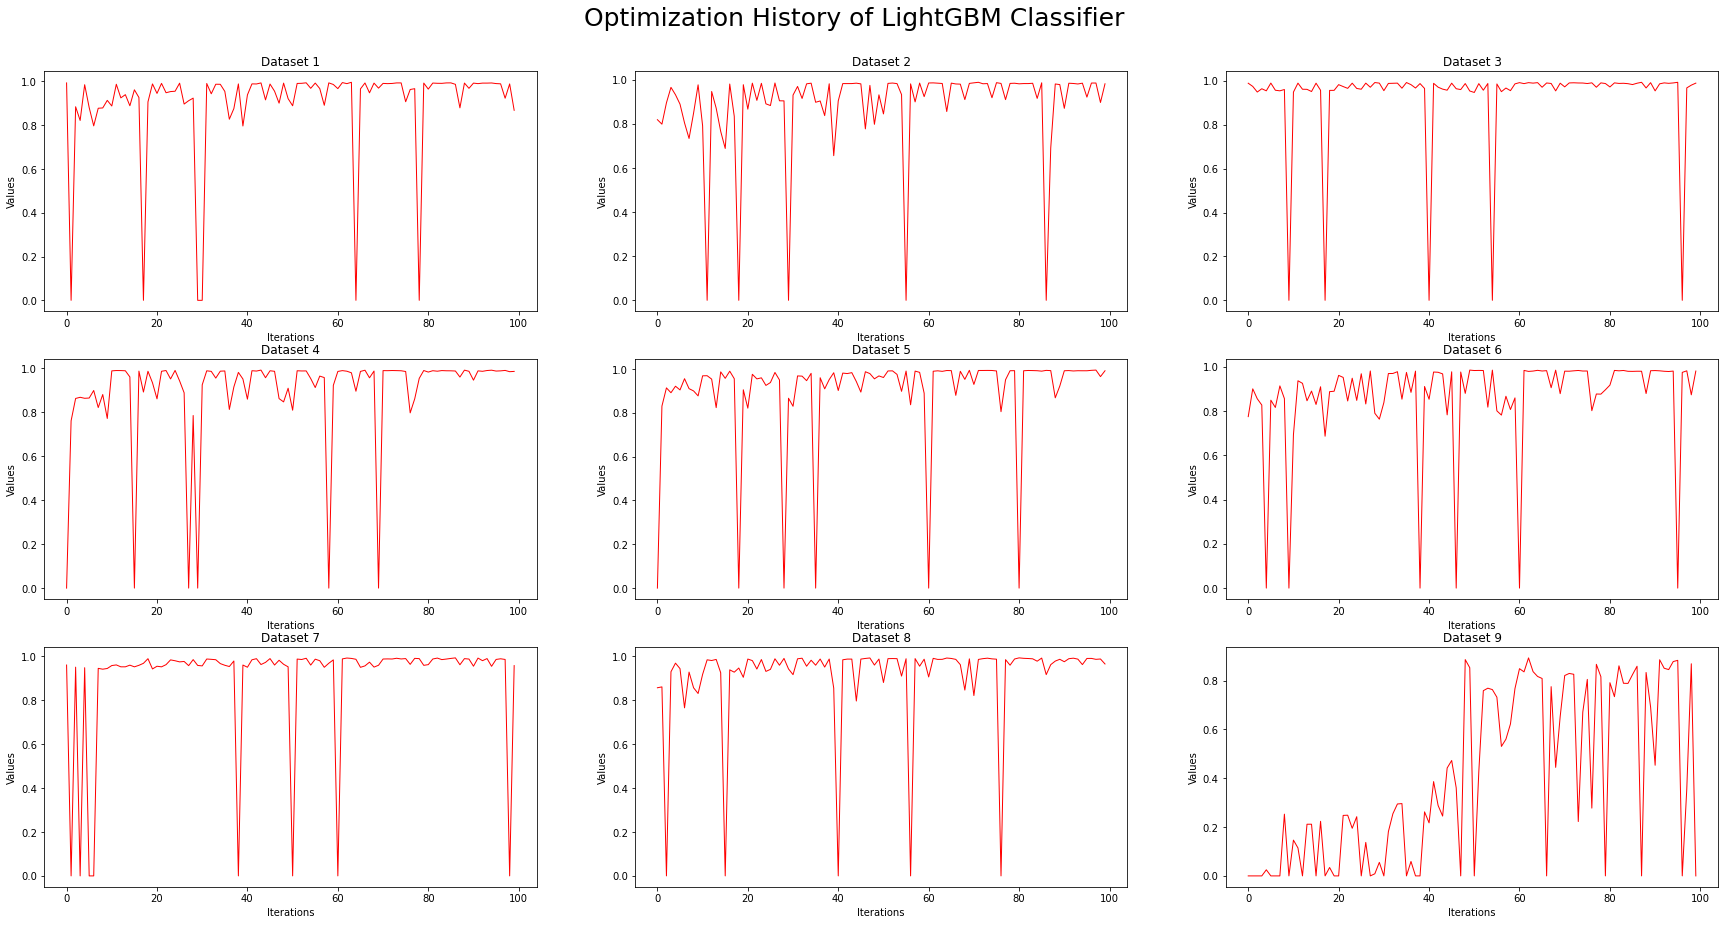

In [33]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'LightGBM Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.0016121384542437174 
Recall: 0.3333333333333333 
Aging Rate: 0.2167567678677876

 Dataset2:
Precision: 0.001188097423988767 
Recall: 0.43137254901960786 
Aging Rate: 0.38062447326769305

 Dataset3:
Precision: 0.0010161662817551962 
Recall: 0.21568627450980393 
Aging Rate: 0.22251228185574215

 Dataset4:
Precision: 0.0011254220332624733 
Recall: 0.17647058823529413 
Aging Rate: 0.1643815905774014

 Dataset5:
Precision: 0.0012322858903265558 
Recall: 0.27450980392156865 
Aging Rate: 0.2335299800612551

 Dataset6:
Precision: 0.0012512512512512512 
Recall: 0.49019607843137253 
Aging Rate: 0.4106970338547555

 Dataset7:
Precision: 0.0012395413696932136 
Recall: 0.3137254901960784 
Aging Rate: 0.2653291948447039

 Dataset8:
Precision: 0.0012610340479192938 
Recall: 0.2549019607843137 
Aging Rate: 0.21190569179222596

 Dataset9:
Precision: 0.0009339446425539141 
Recall: 0.21568627450980393 
Aging Rate: 0.2421015848218874


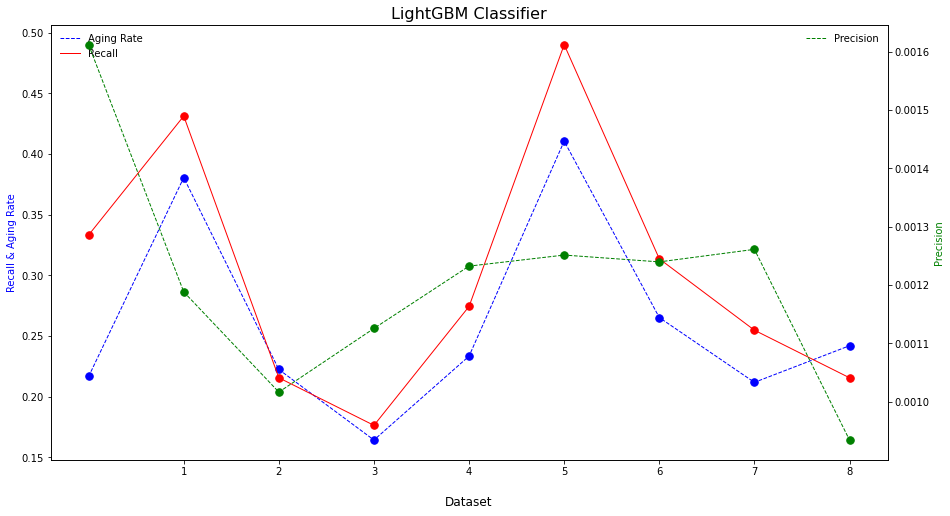

In [34]:
table_setC = runall_LightGBMC(run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'LightGBM Classifier')

In [35]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,17.0,10528.0,34.0,38070.0,0.001612,0.333333,0.216757,1.537822,0.001604,0.310435
dataset2,1.000000,2999.0,2999.0,22.0,18495.0,29.0,30103.0,0.001188,0.431373,0.380624,1.133328,0.001185,0.326844
dataset3,1.000000,3033.0,3033.0,11.0,10814.0,40.0,37784.0,0.001016,0.215686,0.222512,0.969323,0.001011,0.000000
dataset4,1.000000,3038.0,3038.0,9.0,7988.0,42.0,40610.0,0.001125,0.176471,0.164382,1.073542,0.001118,0.128693
dataset5,1.006623,3040.0,3020.0,14.0,11347.0,37.0,37251.0,0.001232,0.274510,0.233530,1.175480,0.001227,0.213363
dataset6,1.014348,3040.0,2997.0,25.0,19955.0,26.0,28643.0,0.001251,0.490196,0.410697,1.193571,0.001248,0.385064
dataset7,1.099458,3040.0,2765.0,16.0,12892.0,35.0,35706.0,0.001240,0.313725,0.265329,1.182401,0.001235,0.244839
dataset8,1.000000,3040.0,3040.0,13.0,10296.0,38.0,38302.0,0.001261,0.254902,0.211906,1.202903,0.001255,0.201315
dataset9,10.000000,3040.0,304.0,11.0,11767.0,40.0,36831.0,0.000934,0.215686,0.242102,0.890892,0.000930,0.000000


#### Calibrated Classifier (optional)

In [ ]:
tableC_1 = all_cali_LightGBMC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'isotonic')
tableC_2 = all_cali_LightGBMC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'sigmoid')
tableC_3 = all_cali_LightGBMC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'beta')

#### Feature Importance

In [ ]:
target = 'set4'

d_train = lgb.Dataset(run_train_x[target], label = run_train_y[target])
d_test = lgb.Dataset(run_test_x, label = run_test_y)
model = lgb.train(best_paramC[target], d_train, 10000, valid_sets = [d_test], early_stopping_rounds = 50, verbose_eval=1000)
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(run_train_x[target])
values = abs(shap_value.values).mean(axis = 0)[:, 1]

shap.summary_plot(shap_values, run_train_x[target])
shap.dependence_plot('label_eqp_ADIEX600', shap_values[1], run_train_x[target])
shap.dependence_plot('label_eqp_ADSPT200', shap_values[1], run_train_x[target], color = shap_values)

In [ ]:
fig = plt.figure(figsize = (24, 8))
colname = run_train[target].columns.to_list()[:-1]
clf = LGBMClassifier(**best_paramC[target])
clf.fit(run_train_x[target], run_train_y[target])
importance = (clf.feature_importances_ / best_paramC[target]['n_estimators']).tolist()
plt.bar(colname, values, color = 'red')
plt.xticks(rotation = 90)
plt.title('20211228_LightGBM_ShapValue')
fig = plt.figure(figsize = (24, 8))
plt.bar(colname, importance, color = 'blue')
plt.xticks(rotation = 90)
plt.title('LightGBM_TreeBasedImportance')

#### Regressor (optional)

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = False, 
                                     n_iter = 10,
                                     filename = 'runhist_array_m2m5_4selection_LightGBM',
                                     creator = LightGBM_creator
                                    )

In [ ]:
pr_dict, table_setR = runall_LightGBMR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'LightGBM Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### Full Experiment

In [5]:
training_month = range(2, 5)
table_setC = full_lightgbm(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 160
# over: 160
Size after Border: 39624

 Generating Dataset 2
Size after Undersampling: 1368
Size after Undersampling: (1368, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 16:55:40,404] A new study created in memory with name: no-name-e78023bd-d582-4f39-ad8f-2fc5d4034e4d


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.898236092265943 
Recall: 0.863102998696219 
Aging Rate: 0.4804432855280313
Precision: 0.9010554089709762 
Recall: 0.8904823989569752 
Aging Rate: 0.4941329856584094
Precision: 0.8870967741935484 
Recall: 0.8604954367666232 
Aging Rate: 0.485006518904824
[I 2022-04-01 16:55:40,633] Trial 0 finished with value: 0.8832168334819547 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 1.8098008559410033, 'reg_lambda': 0.46517730468735663}. Best is trial 0 with value: 0.8832168334819547.
Precision: 0.9038718291054739 
Recall: 0.8826597131681877 
Aging Rate: 0.48826597131681876
Precision: 0.8932291666666666 
Recall: 0.894393741851369 
Aging Rate: 0.500651890482399
Precision: 0.899736147757256 
Recall: 0.8891786179921773 
Aging Rate: 0.4941329856584094
[I 2022-04-01 16:55:41,058] Trial 1 finished with value: 0.8937923820384727 and param

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:55:43,642] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.8591667174047727, 'reg_lambda': 1.9535475206705126}. Best is trial 4 with value: 0.9460168396380387.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:55:43,875] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.023498780455300367, 'reg_lambda': 1.8225286969333487}. Best is trial 4 with value: 0.9460168396380387.
Precision: 0.900523560209424 
Recall: 0.8970013037809648 
Aging Rate: 0.4980443285528031
Precision: 0.9062087186261559 
Recall: 0.894393741851369 
Aging Rate: 0.4934810951760104
Precision: 0.912 
Recall: 0.8917861799217731 
Aging Rate: 0.48891786179921776
[I 2022-04-01 16:55:44,176] Trial 8 finished with value: 0.9002670922862767 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'sub

Precision: 0.9019867549668874 
Recall: 0.8878748370273793 
Aging Rate: 0.4921773142112125
Precision: 0.8964194373401535 
Recall: 0.9139504563233377 
Aging Rate: 0.5097783572359843
Precision: 0.9107856191744341 
Recall: 0.8917861799217731 
Aging Rate: 0.4895697522816167
[I 2022-04-01 16:55:52,136] Trial 20 finished with value: 0.9003869998554409 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.0488788445036802, 'reg_lambda': 0.0962650292798122}. Best is trial 19 with value: 0.9900382016383963.
Precision: 0.984516129032258 
Recall: 0.9947848761408083 
Aging Rate: 0.5052151238591917
Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.9870466321243523 
Recall: 0.9934810951760105 
Aging Rate: 0.5032594524119948
[I 2022-04-01 16:55:54,974] Trial 21 finished with value: 0.99047

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:55:57,999] Trial 24 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.030198487550040256, 'reg_lambda': 0.32892812939057287}. Best is trial 23 with value: 0.9923947050299514.
Sampler is TPESampler

[I 2022-04-01 16:55:58,121] A new study created in memory with name: no-name-549cf4ea-f6e6-4a50-b887-9e063ec3869f



Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8507246376811595 
Recall: 0.7826666666666666 
Aging Rate: 0.46
Precision: 0.8465829846582985 
Recall: 0.8093333333333333 
Aging Rate: 0.478
Precision: 0.822429906542056 
Recall: 0.8213333333333334 
Aging Rate: 0.49933333333333335
[I 2022-04-01 16:55:58,430] Trial 0 finished with value: 0.8215660758615265 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.01890297039193615, 'reg_lambda': 0.01681648383109696}. Best is trial 0 with value: 0.8215660758615265.
Precision: 0.871866295264624 
Recall: 0.8346666666666667 
Aging Rate: 0.4786666666666667
Precision: 0.8622589531680441 
Recall: 0.8346666666666667 
Aging Rate: 0.484
Precision: 0.8519040902679831 
Recall: 0.8053333333333333 
Aging Rate: 0.4726666666666667
[I 2022-04-01 16:55:59,924] Trial 1 finished with value: 0.84302129231909 and parameters: {'n_estimators': 1000, 'learnin

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:00,183] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.4458431382939927, 'reg_lambda': 9.803490523289591}. Best is trial 1 with value: 0.84302129231909.
Precision: 0.7290322580645161 
Recall: 0.7533333333333333 
Aging Rate: 0.5166666666666667
Precision: 0.7202007528230866 
Recall: 0.7653333333333333 
Aging Rate: 0.5313333333333333
Precision: 0.7340425531914894 
Recall: 0.736 
Aging Rate: 0.5013333333333333
[I 2022-04-01 16:56:00,536] Trial 3 finished with value: 0.7393616759633398 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.2912458508859131, 'reg_lambda': 0.01649347575

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:01,315] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.02952293657935083, 'reg_lambda': 8.138084218339298}. Best is trial 1 with value: 0.84302129231909.
Precision: 0.8404255319148937 
Recall: 0.8426666666666667 
Aging Rate: 0.5013333333333333
Precision: 0.8696236559139785 
Recall: 0.8626666666666667 
Aging Rate: 0.496
Precision: 0.8497340425531915 
Recall: 0.852 
Aging Rate: 0.5013333333333333
[I 2022-04-01 16:56:01,900] Trial 6 finished with value: 0.8528471037575365 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subs

Precision: 0.8761528326745718 
Recall: 0.8866666666666667 
Aging Rate: 0.506
Precision: 0.8875 
Recall: 0.852 
Aging Rate: 0.48
Precision: 0.8836265223274695 
Recall: 0.8706666666666667 
Aging Rate: 0.49266666666666664
[I 2022-04-01 16:56:10,499] Trial 18 finished with value: 0.8759549584555989 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 3.2937825269056784, 'reg_lambda': 2.8847966176444415}. Best is trial 16 with value: 0.9814064519367743.
Precision: 0.9662618083670715 
Recall: 0.9546666666666667 
Aging Rate: 0.494
Precision: 0.9640479360852197 
Recall: 0.9653333333333334 
Aging Rate: 0.5006666666666667
Precision: 0.9731543624161074 
Recall: 0.9666666666666667 
Aging Rate: 0.49666666666666665
[I 2022-04-01 16:56:10,968] Trial 19 finished with value: 0.9650063714000677 and parameters: {'n_estimators': 300, 'learning_rate

[I 2022-04-01 16:56:13,175] A new study created in memory with name: no-name-cbe382f1-01b3-40d0-8bd3-9645c57d8474


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.998546511627907 
Recall: 0.9039473684210526 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.8973684210526316 
Aging Rate: 0.4486842105263158
[I 2022-04-01 16:56:13,484] Trial 0 finished with value: 0.9488425420089704 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.1576510084256459, 'reg_lambda': 1.025312004979455}. Best is trial 0 with value: 0.9488425420089704.
Precision: 0.9959072305593452 
Recall: 0.9605263157894737 
Aging Rate: 0.48223684210526313
Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
Precision: 0.9986149584487535 
Recall: 0.9486842105263158 
Aging Rate: 0.475
[I 2022-04-01 16:56:14,114] Trial 1 finished with value: 0.9771694351195027 and parameters: {'n_estimators'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:21,570] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.1816533604983716, 'reg_lambda': 8.279241649808695}. Best is trial 10 with value: 0.9817265473956835.
Precision: 1.0 
Recall: 0.8960526315789473 
Aging Rate: 0.44802631578947366
Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
Precision: 1.0 
Recall: 0.9026315789473685 
Aging Rate: 0.4513157894736842
[I 2022-04-01 16:56:21,981] Trial 14 finished with value: 0.9500150865011022 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 8.958411629304912, 'reg_lambda': 1.5811746938449056}. B

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:23,405] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 1.8767140547055374, 'reg_lambda': 9.428738832783361}. Best is trial 10 with value: 0.9817265473956835.
Precision: 1.0 
Recall: 0.9302631578947368 
Aging Rate: 0.4651315789473684
Precision: 1.0 
Recall: 0.925 
Aging Rate: 0.4625
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-04-01 16:56:23,734] Trial 19 finished with value: 0.959599771628196 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 3.8832867649844647, 'reg_lambda': 1.185710823136753}. Best is trial 10 w

[I 2022-04-01 16:56:26,256] A new study created in memory with name: no-name-7aa12736-e88e-49e3-996b-bee8334ec48a


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.7530695770804912 
Recall: 0.7263157894736842 
Aging Rate: 0.48223684210526313
Precision: 0.7740585774058577 
Recall: 0.7302631578947368 
Aging Rate: 0.47171052631578947
Precision: 0.7877551020408163 
Recall: 0.7618421052631579 
Aging Rate: 0.48355263157894735
[I 2022-04-01 16:56:26,432] Trial 0 finished with value: 0.755185356072993 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 6.728434994667855, 'reg_lambda': 0.3540920299839332}. Best is trial 0 with value: 0.755185356072993.
Precision: 0.7949061662198391 
Recall: 0.7802631578947369 
Aging Rate: 0.49078947368421055
Precision: 0.7785326086956522 
Recall: 0.7539473684210526 
Aging Rate: 0.4842105263157895
Precision: 0.7563249001331558 
Recall: 0.7473684210526316 
Aging Rate: 0.49407894736842106
[I 2022-04-01 16:56:26,784] Trial 1 finished with value: 0.768459

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:28,102] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.1302940966232335, 'reg_lambda': 0.36851141435432105}. Best is trial 3 with value: 0.8457600319292381.
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9789196310935442 
Recall: 0.9776315789473684 
Aging Rate: 0.4993421052631579
[I 2022-04-01 16:56:28,812] Trial 6 finished with value: 0.9830312976491652 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_byt

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:34,461] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.02723618567929168, 'reg_lambda': 0.5392885488032185}. Best is trial 15 with value: 0.9902845870275141.
Precision: 0.8888888888888888 
Recall: 0.9368421052631579 
Aging Rate: 0.5269736842105263
Precision: 0.8823529411764706 
Recall: 0.9276315789473685 
Aging Rate: 0.5256578947368421
Precision: 0.9228723404255319 
Recall: 0.9131578947368421 
Aging Rate: 0.49473684210526314
[I 2022-04-01 16:56:34,829] Trial 18 finished with value: 0.9115503594511161 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha':

[I 2022-04-01 16:56:39,755] A new study created in memory with name: no-name-5e315e9f-fd13-41b4-8520-16f70b30ab40


Precision: 0.9566929133858267 
Recall: 0.9592105263157895 
Aging Rate: 0.5013157894736842
[I 2022-04-01 16:56:39,649] Trial 24 finished with value: 0.9634029891317075 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.039130301923456914, 'reg_lambda': 0.06098058258139266}. Best is trial 15 with value: 0.9902845870275141.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.869753979739508 
Recall: 0.7960264900662252 
Aging Rate: 0.4561056105610561
Precision: 0.8672438672438673 
Recall: 0.7960264900662252 
Aging Rate: 0.45742574257425744
Precision: 0.8491620111731844 
Recall: 0.8052980132450331 
Aging Rate: 0.4726072607260726
[I 2022-04-01 16:56:40,000] Trial 0 finished with value: 0.8293392267278223 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.010644224870302005, 'reg_lambda': 0.6288248825745545}. Best is trial 0 with value: 0.8293392267278223.
Precision: 0.8514115898959881 
Recall: 0.7589403973509934 
Aging Rate: 0.44422442244224425
Precision: 0.841799709724238 
Recall: 0.7682119205298014 
Aging Rate: 0.4547854785478548
Precision: 0.8319209039548022 
Recall: 0.7801324503311259 
Aging Rate: 0.46732673267326735
[I 2022-04-01 16:56:40,369] Trial 1 finished with value: 0.8036

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:44,427] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.2266509316047892, 'reg_lambda': 0.04182411828482957}. Best is trial 6 with value: 0.9889886799703014.
Precision: 0.8337912087912088 
Recall: 0.8039735099337748 
Aging Rate: 0.48052805280528055
Precision: 0.8565340909090909 
Recall: 0.7986754966887417 
Aging Rate: 0.4646864686468647
Precision: 0.8492957746478873 
Recall: 0.7986754966887417 
Aging Rate: 0.46864686468646866
[I 2022-04-01 16:56:44,848] Trial 8 finished with value: 0.822804224053454 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.15903064042663656, 'reg_lambda': 0.6630215

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:48,953] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 3.8567049678411625, 'reg_lambda': 1.5542203880324081}. Best is trial 6 with value: 0.9889886799703014.
Precision: 0.981651376146789 
Recall: 0.9920529801324504 
Aging Rate: 0.5036303630363036
Precision: 0.9778067885117493 
Recall: 0.9920529801324504 
Aging Rate: 0.5056105610561056
Precision: 0.9777486910994765 
Recall: 0.9894039735099338 
Aging Rate: 0.5042904290429043
[I 2022-04-01 16:56:49,477] Trial 19 finished with value: 0.9850816475818402 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytr

[I 2022-04-01 16:56:51,535] A new study created in memory with name: no-name-a9a708bd-1c77-4bc2-8673-103cdda2fd87


Precision: 0.9430051813471503 
Recall: 0.9642384105960264 
Aging Rate: 0.5095709570957095
Precision: 0.9427828348504551 
Recall: 0.9602649006622517 
Aging Rate: 0.5075907590759076
[I 2022-04-01 16:56:51,432] Trial 24 finished with value: 0.95526551366532 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.4564174526673557, 'reg_lambda': 4.070342059908075}. Best is trial 6 with value: 0.9889886799703014.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.7283072546230441 
Recall: 0.681757656458056 
Aging Rate: 0.46525479814692255
Precision: 0.7138728323699421 
Recall: 0.6577896138482024 
Aging Rate: 0.45797485109199204
Precision: 0.6985583224115334 
Recall: 0.7097203728362184 
Aging Rate: 0.5049636002647253
[I 2022-04-01 16:56:51,729] Trial 0 finished with value: 0.6976812986690534 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.17022813745622625, 'reg_lambda': 0.03343229886206254}. Best is trial 0 with value: 0.6976812986690534.
Precision: 0.6894243641231593 
Recall: 0.6857523302263648 
Aging Rate: 0.4943745863666446
Precision: 0.7054973821989529 
Recall: 0.7177097203728362 
Aging Rate: 0.5056254136333554
Precision: 0.7030386740331491 
Recall: 0.677762982689747 
Aging Rate: 0.47915287888815355
[I 2022-04-01 16:56:52,326] Trial 1 finished with value: 0.6964346970779086 a

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:56:55,877] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 8.281220653510639, 'reg_lambda': 9.59126827219144}. Best is trial 2 with value: 0.8581850739666494.
Precision: 0.8359264497878359 
Recall: 0.7869507323568575 
Aging Rate: 0.46790205162144277
Precision: 0.8218390804597702 
Recall: 0.7616511318242344 
Aging Rate: 0.46062210456651226
Precision: 0.8116343490304709 
Recall: 0.7802929427430093 
Aging Rate: 0.47782925215089345
[I 2022-04-01 16:56:56,268] Trial 11 finished with value: 0.7989853193414662 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, '

Precision: 0.9426666666666667 
Recall: 0.9414114513981359 
Aging Rate: 0.49636002647253474
Precision: 0.9195849546044098 
Recall: 0.9440745672436751 
Aging Rate: 0.5102581072137657
Precision: 0.9355263157894737 
Recall: 0.9467376830892144 
Aging Rate: 0.5029781601588352
[I 2022-04-01 16:57:05,281] Trial 23 finished with value: 0.9382687026218001 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 4.302082591236097, 'reg_lambda': 0.10826762398262975}. Best is trial 14 with value: 0.9626032344388736.
Precision: 0.9202702702702703 
Recall: 0.9067909454061251 
Aging Rate: 0.48974189278623426
Precision: 0.9245033112582781 
Recall: 0.929427430093209 
Aging Rate: 0.499669093315685


[I 2022-04-01 16:57:06,077] A new study created in memory with name: no-name-ad458105-1255-47d8-a159-5c3fce20fb59


Precision: 0.9356164383561644 
Recall: 0.9094540612516645 
Aging Rate: 0.4831237590999338
[I 2022-04-01 16:57:05,971] Trial 24 finished with value: 0.9209298267754557 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.8090304106271629, 'reg_lambda': 0.01653016513531345}. Best is trial 14 with value: 0.9626032344388736.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9985734664764622 
Recall: 0.9210526315789473 
Aging Rate: 0.4611842105263158
Precision: 0.9971711456859972 
Recall: 0.9276315789473685 
Aging Rate: 0.4651315789473684
Precision: 1.0 
Recall: 0.925 
Aging Rate: 0.4625
[I 2022-04-01 16:57:06,280] Trial 0 finished with value: 0.9601439769364083 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.2284765003311707, 'reg_lambda': 0.07675269030784995}. Best is trial 0 with value: 0.9601439769364083.
Precision: 0.9985632183908046 
Recall: 0.9144736842105263 
Aging Rate: 0.45789473684210524
Precision: 0.9971139971139971 
Recall: 0.9092105263157895 
Aging Rate: 0.45592105263157895
Precision: 0.9985795454545454 
Recall: 0.925 
Aging Rate: 0.4631578947368421
[I 2022-04-01 16:57:06,913] Trial 1 finished with value: 0.9553961416289781 and parameters: {'n_estimators': 1000, 'learning_rate': 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:10,738] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 9.326915447300774, 'reg_lambda': 0.011067366521005609}. Best is trial 5 with value: 0.9740106527438043.
Precision: 0.9971631205673759 
Recall: 0.925 
Aging Rate: 0.46381578947368424
Precision: 0.9985775248933144 
Recall: 0.9236842105263158 
Aging Rate: 0.4625
Precision: 0.9944211994421199 
Recall: 0.9381578947368421 
Aging Rate: 0.47171052631578947
[I 2022-04-01 16:57:11,170] Trial 11 finished with value: 0.9616231393022009 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.9693338542826148, 'reg_lambda'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:13,063] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 3.3082544861792385, 'reg_lambda': 0.024867436630374107}. Best is trial 13 with value: 0.9887200936066046.
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
[I 2022-04-01 16:57:13,714] Trial 16 finished with value: 0.9851292823900145 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.5713311707737797, 'reg_lambda': 9.855517833408499}. Best is trial

[I 2022-04-01 16:57:18,949] A new study created in memory with name: no-name-1dbef1fb-f5a7-45db-b915-b615f9b43d57


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:19,110] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.06592987124437286, 'reg_lambda': 0.23833213717417484}. Best is trial 0 with value: 0.0.
Precision: 0.9775132275132276 
Recall: 0.9723684210526315 
Aging Rate: 0.49736842105263157
Precision: 0.9771812080536912 
Recall: 0.9578947368421052 
Aging Rate: 0.4901315789473684
Precision: 0.9634464751958225 
Recall: 0.9710526315789474 
Aging Rate: 0.5039473684210526
[I 2022-04-01 16:57:20,085] Trial 1 finished with value: 0.969870165888851 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'sub

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:20,333] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.1681566564213535, 'reg_lambda': 0.4323408049962307}. Best is trial 1 with value: 0.969870165888851.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:20,577] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.18869171044036867, 'reg_lambda': 5.4513471976631624}. Best is trial 1 with value: 0.969870165888851.
Precision: 0.8341708542713567 
Recall: 0.8736842105263158 
Aging Rate: 0.5236842105263158
Precision: 0.8498659517426274 
Recall: 0.8342105263157895 
Aging Rate: 0.49078947368421055
Precision: 0.8322903629536921 
Recall: 0.875 
Aging Rate: 0.5256578947368421
[I 2022-04-01 16:57:21,253] Trial 4 finished with value: 0.8495156256783781 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.115407759176

Precision: 0.943078913324709 
Recall: 0.9592105263157895 
Aging Rate: 0.5085526315789474
Precision: 0.9381443298969072 
Recall: 0.9578947368421052 
Aging Rate: 0.5105263157894737
Precision: 0.9362244897959183 
Recall: 0.9657894736842105 
Aging Rate: 0.5157894736842106
[I 2022-04-01 16:57:29,745] Trial 16 finished with value: 0.9499233965595133 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.012476536267136271, 'reg_lambda': 2.165386028077673}. Best is trial 15 with value: 0.9896847348996554.
Precision: 0.8240620957309185 
Recall: 0.8381578947368421 
Aging Rate: 0.5085526315789474
Precision: 0.8038461538461539 
Recall: 0.825 
Aging Rate: 0.5131578947368421
Precision: 0.8342036553524804 
Recall: 0.8407894736842105 
Aging Rate: 0.5039473684210526
[I 2022-04-01 16:57:30,245] Trial 17 finished with value: 0.8276065199654492 and parameters: 

[I 2022-04-01 16:57:36,461] A new study created in memory with name: no-name-063e56bb-03e7-488b-8b0f-8967e95f6b47


Precision: 0.9179292929292929 
Recall: 0.9565789473684211 
Aging Rate: 0.5210526315789473
[I 2022-04-01 16:57:36,348] Trial 24 finished with value: 0.9441545991739558 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.5710199006779177, 'reg_lambda': 9.204251507918595}. Best is trial 15 with value: 0.9896847348996554.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:36,836] Trial 0 finished with value: 0.03397446435421119 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5.767254309148634, 'reg_lambda': 0.01008463356960359}. Best is trial 0 with value: 0.03397446435421119.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
[I 2022-04-01 16:57:37,103] Trial 1 finished with value: 0.008658008658008658 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.633266501421841, 'reg_lambda': 2.363682099871925}. Best is trial 0 with value: 0.03397446435421119.
Precision: 0.8928571428571429 
Recall: 0.32894736842105265 
Aging Rate: 0.03349282296650718
Precision: 0.9 
Recall: 0.11842105263157894 
Aging Rate: 0.011961722488038277
Precision: 0.9047619047619048 
Recall: 0.25 
Aging Rate: 0.025119617224880382
[I 2022-04-01 16:57:37,352] Trial 2 finished with value: 0.36060804455673795 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_by

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:37,647] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 9.144867430873743, 'reg_lambda': 0.017818718982369117}. Best is trial 2 with value: 0.36060804455673795.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.15298507462686567 
Recall: 0.5394736842105263 
Aging Rate: 0.32057416267942584
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:37,896] Trial 4 finished with value: 0.07945736434108526 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.1351233383404097, 'reg_lambda': 1.0534695820652813}. Best is trial 2 with value: 0.36060804455673795.
Precision: 0.875 
Recall: 0.18421052631578946 
Aging Rate: 0.019138755980861243
Precision: 1.0 
Recall: 0.11842105263157894 
Aging Rate: 0.01076555023923445
Precision: 0.8571428571428571 
Recall: 0.15789473684210525 
Aging Rate: 0.01674641148325359
[I 2022-04-01 16:57:38,162] Trial 5 finished with value: 0.2609263995453253 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:39,037] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.030864533203079223, 'reg_lambda': 0.18809704215018058}. Best is trial 2 with value: 0.36060804455673795.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:39,274] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.3116899648952984, 'reg_lambda': 0.10350589939300098}. Best is trial 2 with value: 0.36060804455673795.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:39,565] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.16651012762797365, 'reg_lambda': 8.122265529460934}. Best is trial 2 with value: 0.36060804455673795.
Precision: 0.8333333333333334 
Recall: 0.13157894736842105 
Aging Rate: 0.014354066985645933
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
[I 2022-04-01 16:57:39,851] Trial 11 finished with value: 0.23079633544749822 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subs

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:57:43,129] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.30156811205107076, 'reg_lambda': 0.04971127576390397}. Best is trial 16 with value: 0.8836211616933545.
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
[I 2022-04-01 16:57:43,767] Trial 18 finished with value: 0.8781609195402299 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.13978964984730988, 'reg_lambda': 0.5

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39623

 Generating Dataset 2
Size after Undersampling: 1366
Size after Undersampling: (1366, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 16:59:21,131] A new study created in memory with name: no-name-687f3514-2b7b-44df-8210-24135de8f964


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:21,299] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.0500135992813297, 'reg_lambda': 0.04468249690693866}. Best is trial 0 with value: 0.0.
Precision: 0.8402777777777778 
Recall: 0.788787483702738 
Aging Rate: 0.46936114732724904
Precision: 0.8393351800554016 
Recall: 0.7900912646675359 
Aging Rate: 0.4706649282920469
Precision: 0.8433566433566434 
Recall: 0.7861799217731421 
Aging Rate: 0.4661016949152542
[I 2022-04-01 16:59:21,802] Trial 1 finished with value: 0.8138177286925276 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytr

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:22,996] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 9.082731613440053, 'reg_lambda': 1.1877218042331132}. Best is trial 3 with value: 0.8417042662561803.
Precision: 0.8078602620087336 
Recall: 0.7235984354628422 
Aging Rate: 0.44784876140808344
Precision: 0.8325652841781874 
Recall: 0.7066492829204694 
Aging Rate: 0.424380704041721
Precision: 0.8352601156069365 
Recall: 0.7535853976531942 
Aging Rate: 0.4511082138200782
[I 2022-04-01 16:59:23,427] Trial 5 finished with value: 0.7733972567156466 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_byt

Precision: 0.9099216710182768 
Recall: 0.9087353324641461 
Aging Rate: 0.49934810951760106
Precision: 0.9070080862533693 
Recall: 0.877444589308996 
Aging Rate: 0.48370273794002605
Precision: 0.9098143236074271 
Recall: 0.894393741851369 
Aging Rate: 0.4915254237288136
[I 2022-04-01 16:59:29,950] Trial 17 finished with value: 0.9011158974267572 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.928587028012118, 'reg_lambda': 0.42634050386985056}. Best is trial 16 with value: 0.9906710523770014.
Precision: 0.9415670650730412 
Recall: 0.924380704041721 
Aging Rate: 0.4908735332464146
Precision: 0.9322033898305084 
Recall: 0.9322033898305084 
Aging Rate: 0.5
Precision: 0.930628272251309 
Recall: 0.9269882659713168 
Aging Rate: 0.4980443285528031
[I 2022-04-01 16:59:30,507] Trial 18 finished with value: 0.9313009431604118 and

[I 2022-04-01 16:59:34,113] A new study created in memory with name: no-name-afb2a6c8-04ed-4f93-9995-f8e711737dc6


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.7090163934426229 
Recall: 0.6910785619174434 
Aging Rate: 0.4873501997336884
Precision: 0.681045751633987 
Recall: 0.6937416777629827 
Aging Rate: 0.5093209054593875
Precision: 0.6967654986522911 
Recall: 0.6884154460719041 
Aging Rate: 0.4940079893475366
[I 2022-04-01 16:59:34,366] Trial 0 finished with value: 0.6932776554068222 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1.592699894480245, 'reg_lambda': 0.019871690436903584}. Best is trial 0 with value: 0.6932776554068222.
Precision: 0.8355263157894737 
Recall: 0.8455392809587217 
Aging Rate: 0.5059920106524634
Precision: 0.8498694516971279 
Recall: 0.8668442077230359 
Aging Rate: 0.5099866844207723
Precision: 0.8351648351648352 
Recall: 0.8095872170439414 
Aging Rate: 0.48468708388814913
[I 2022-04-01 16:59:34,842] Trial 1 finished with value: 0.8403176773114369 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:35,982] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.7281336293038829, 'reg_lambda': 0.04797667247315871}. Best is trial 2 with value: 0.8776275082176715.
Precision: 0.9801324503311258 
Recall: 0.9853528628495339 
Aging Rate: 0.5026631158455392
Precision: 0.9798927613941019 
Recall: 0.9733688415446072 
Aging Rate: 0.4966711051930759
Precision: 0.983957219251337 
Recall: 0.9800266311584553 
Aging Rate: 0.4980026631158455
[I 2022-04-01 16:59:37,129] Trial 5 finished with value: 0.9804478740819564 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 0, 'co

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:37,403] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 2.6518887919111362, 'reg_lambda': 3.100239524755346}. Best is trial 5 with value: 0.9804478740819564.
Precision: 0.7659574468085106 
Recall: 0.7669773635153129 
Aging Rate: 0.5006657789613849
Precision: 0.7460732984293194 
Recall: 0.758988015978695 
Aging Rate: 0.5086551264980027
Precision: 0.7547408343868521 
Recall: 0.7949400798934754 
Aging Rate: 0.5266311584553928
[I 2022-04-01 16:59:37,692] Trial 7 finished with value: 0.7644204598469587 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsampl

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:37,936] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.09271320573094609, 'reg_lambda': 0.9244683880085357}. Best is trial 5 with value: 0.9804478740819564.
Precision: 0.7308192457737321 
Recall: 0.748335552596538 
Aging Rate: 0.5119840213049268
Precision: 0.6951530612244898 
Recall: 0.725699067909454 
Aging Rate: 0.521970705725699
Precision: 0.684 
Recall: 0.6830892143808256 
Aging Rate: 0.4993342210386152
[I 2022-04-01 16:59:38,652] Trial 9 finished with value: 0.7110385692925671 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'sub

Precision: 0.9907038512616202 
Recall: 0.9933422103861518 
Aging Rate: 0.5013315579227696
Precision: 0.9840213049267643 
Recall: 0.9840213049267643 
Aging Rate: 0.5
Precision: 0.9853917662682603 
Recall: 0.9880159786950732 
Aging Rate: 0.5013315579227696
[I 2022-04-01 16:59:46,011] Trial 21 finished with value: 0.987581569727361 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.01980967105183099, 'reg_lambda': 0.8452855396678082}. Best is trial 21 with value: 0.987581569727361.
Precision: 0.9037433155080213 
Recall: 0.9001331557922769 
Aging Rate: 0.4980026631158455
Precision: 0.8938401048492791 
Recall: 0.9081225033288948 
Aging Rate: 0.5079893475366178
Precision: 0.9043824701195219 
Recall: 0.9067909454061251 
Aging Rate: 0.5013315579227696
[I 2022-04-01 16:59:46,352] Trial 22 finished with value: 0.9028148107463806 and parameters: {'n

[I 2022-04-01 16:59:47,537] A new study created in memory with name: no-name-3abde00f-a65d-4c0a-862b-174c18c15776


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 0.9985611510791367 
Recall: 0.9131578947368421 
Aging Rate: 0.45723684210526316
Precision: 1.0 
Recall: 0.8934210526315789 
Aging Rate: 0.44671052631578945
[I 2022-04-01 16:59:47,849] Trial 0 finished with value: 0.9481005823425747 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 1.1894620229692785, 'reg_lambda': 0.022991434795770906}. Best is trial 0 with value: 0.9481005823425747.
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-04-01 16:59:48,536] Trial 1 finished with value: 0.9878268968902688 and parameters: {'n_estimato

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:48,756] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.06674351364142242, 'reg_lambda': 0.013997603535037373}. Best is trial 1 with value: 0.9878268968902688.
Precision: 1.0 
Recall: 0.925 
Aging Rate: 0.4625
Precision: 0.997093023255814 
Recall: 0.9026315789473685 
Aging Rate: 0.45263157894736844
Precision: 0.9941775836972343 
Recall: 0.8986842105263158 
Aging Rate: 0.4519736842105263
[I 2022-04-01 16:59:49,366] Trial 3 finished with value: 0.950858295971256 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.050634057281935346, 'reg_lambda': 1.1413929657283444}. Best is trial 1 with valu

Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-04-01 16:59:55,373] Trial 15 finished with value: 0.9509803096581294 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.13347627271263438, 'reg_lambda': 0.5482232610869548}. Best is trial 1 with value: 0.9878268968902688.
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.4605263157894737
Precision: 1.0 
Recall: 0.8947368421052632 
Aging Rate: 0.4473684210526316
[I 2022-04-01 16:59:56,051] Trial 16 finished with value: 0.9519317141976998 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 5.131387350242399, 'reg_lambda': 4.6553

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 16:59:57,108] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.67937420507545, 'reg_lambda': 0.03279189562288249}. Best is trial 1 with value: 0.9878268968902688.
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.9 
Aging Rate: 0.45
Precision: 0.9985549132947977 
Recall: 0.9092105263157895 
Aging Rate: 0.45526315789473687
[I 2022-04-01 16:59:57,515] Trial 20 finished with value: 0.9500532482641907 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.08508849074835376, 'reg_lambda': 0.3446909447696271}. Best is trial 1 with value: 0.9878268968902688.
Pr

[I 2022-04-01 16:59:59,599] A new study created in memory with name: no-name-3d077d14-45c7-4ca0-b3f2-9e14a6d5d79a


Precision: 0.9971509971509972 
Recall: 0.9210526315789473 
Aging Rate: 0.4618421052631579
[I 2022-04-01 16:59:59,499] Trial 24 finished with value: 0.9540701103567842 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.10736583310905606, 'reg_lambda': 0.010796662615104057}. Best is trial 1 with value: 0.9878268968902688.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8310626702997275 
Recall: 0.8026315789473685 
Aging Rate: 0.48289473684210527
Precision: 0.8492791612057667 
Recall: 0.8526315789473684 
Aging Rate: 0.5019736842105263
Precision: 0.8484472049689441 
Recall: 0.8986842105263158 
Aging Rate: 0.5296052631578947
[I 2022-04-01 17:00:00,017] Trial 0 finished with value: 0.8467984170092976 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 3.377892627735739, 'reg_lambda': 0.26096812957718307}. Best is trial 0 with value: 0.8467984170092976.
Precision: 0.7663934426229508 
Recall: 0.7381578947368421 
Aging Rate: 0.48157894736842105
Precision: 0.7567204301075269 
Recall: 0.7407894736842106 
Aging Rate: 0.48947368421052634
Precision: 0.7735602094240838 
Recall: 0.7776315789473685 
Aging Rate: 0.5026315789473684
[I 2022-04-01 17:00:00,420] Trial 1 finished with value: 0.7587571626025499 a

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:03,472] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.035942318267655246, 'reg_lambda': 1.2212747479614734}. Best is trial 4 with value: 0.9354823292278248.
Precision: 0.8204456094364351 
Recall: 0.8236842105263158 
Aging Rate: 0.5019736842105263
Precision: 0.8120204603580563 
Recall: 0.8355263157894737 
Aging Rate: 0.5144736842105263
Precision: 0.8199737187910644 
Recall: 0.8210526315789474 
Aging Rate: 0.5006578947368421
[I 2022-04-01 17:00:03,902] Trial 9 finished with value: 0.8220600825586378 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:06,532] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.03613048917911984, 'reg_lambda': 3.374576882700841}. Best is trial 12 with value: 0.9633868008761007.
Precision: 0.9157088122605364 
Recall: 0.9434210526315789 
Aging Rate: 0.5151315789473684
Precision: 0.9317010309278351 
Recall: 0.9513157894736842 
Aging Rate: 0.5105263157894737
Precision: 0.9291237113402062 
Recall: 0.9486842105263158 
Aging Rate: 0.5105263157894737
[I 2022-04-01 17:00:06,893] Trial 17 finished with value: 0.9365222420249154 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.9

[I 2022-04-01 17:00:10,479] A new study created in memory with name: no-name-7cf0e1ee-37a3-4563-946a-72a29927420f


Precision: 0.9745649263721553 
Recall: 0.9578947368421052 
Aging Rate: 0.49144736842105263
[I 2022-04-01 17:00:10,370] Trial 24 finished with value: 0.9728777257287772 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.013402810471393925, 'reg_lambda': 3.8544115847987452}. Best is trial 19 with value: 0.9825545489031159.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.873758865248227 
Recall: 0.8158940397350993 
Aging Rate: 0.46534653465346537
Precision: 0.8453900709219858 
Recall: 0.7894039735099337 
Aging Rate: 0.46534653465346537
Precision: 0.8538011695906432 
Recall: 0.7735099337748345 
Aging Rate: 0.4514851485148515
[I 2022-04-01 17:00:10,702] Trial 0 finished with value: 0.8239829155838181 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.20010992277414136, 'reg_lambda': 7.8308078262038245}. Best is trial 0 with value: 0.8239829155838181.
Precision: 0.9267643142476698 
Recall: 0.9218543046357616 
Aging Rate: 0.4957095709570957
Precision: 0.9027237354085603 
Recall: 0.9218543046357616 
Aging Rate: 0.5089108910891089
Precision: 0.9077922077922078 
Recall: 0.9258278145695364 
Aging Rate: 0.5082508250825083
[I 2022-04-01 17:00:11,143] Trial 1 finished with value: 0.917737609674174 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:13,476] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 3.938913471461129, 'reg_lambda': 0.8560279044239851}. Best is trial 4 with value: 0.9506807144922931.
Precision: 0.8847262247838616 
Recall: 0.8132450331125828 
Aging Rate: 0.45808580858085807
Precision: 0.8856345885634589 
Recall: 0.8410596026490066 
Aging Rate: 0.47326732673267324
Precision: 0.8599439775910365 
Recall: 0.8132450331125828 
Aging Rate: 0.47128712871287126
[I 2022-04-01 17:00:14,273] Trial 8 finished with value: 0.848731859589401 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 12,

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:22,545] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.07037815251387816, 'reg_lambda': 0.033315310682748976}. Best is trial 14 with value: 0.9920521002667009.
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9854497354497355 
Recall: 0.9867549668874173 
Aging Rate: 0.499009900990099
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2022-04-01 17:00:23,655] Trial 18 finished with value: 0.9907337322035105 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0,

[I 2022-04-01 17:00:28,134] A new study created in memory with name: no-name-2773c8c7-e85f-49cd-b5e9-a8fafe8f692c


[I 2022-04-01 17:00:28,027] Trial 24 finished with value: 0.9544485051186792 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.10396643982977098, 'reg_lambda': 0.06680990721562441}. Best is trial 14 with value: 0.9920521002667009.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.768033946251768 
Recall: 0.7230359520639148 
Aging Rate: 0.46790205162144277
Precision: 0.7642857142857142 
Recall: 0.7123834886817576 
Aging Rate: 0.4632693580410324
Precision: 0.7523427041499331 
Recall: 0.748335552596538 
Aging Rate: 0.4943745863666446
[I 2022-04-01 17:00:28,329] Trial 0 finished with value: 0.7442040709044355 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.647011569607151, 'reg_lambda': 0.8613585354277215}. Best is trial 0 with value: 0.7442040709044355.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:28,566] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.019525912167956423, 'reg_lambda': 0.38547452343632155}. Best is trial 0 with value: 0.7442040709044355.
Precision: 0.8998628257887518 
Recall: 0.8735019973368842 
Aging Rate: 0.4824619457313038
Precision: 0.9059139784946236 
Recall: 0.8974700399467377 
Aging Rate: 0.4923891462607545
Precision: 0.905608755129959 
Recall: 0.881491344873502 
Aging Rate: 0.48378557246856385
[I 2022-04-01 17:00:29,130] Trial 2 finished with value: 0.8938486805763693 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 50, 'min_spl

Precision: 0.9802631578947368 
Recall: 0.9920106524633822 
Aging Rate: 0.5029781601588352
Precision: 0.986648865153538 
Recall: 0.9840213049267643 
Aging Rate: 0.4956982131039047
Precision: 0.9841059602649007 
Recall: 0.9893475366178429 
Aging Rate: 0.499669093315685
[I 2022-04-01 17:00:35,345] Trial 14 finished with value: 0.9860516800362342 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.010404680814407824, 'reg_lambda': 0.0535509274998514}. Best is trial 14 with value: 0.9860516800362342.
Precision: 0.9466840052015605 
Recall: 0.9693741677762983 
Aging Rate: 0.5089344804765056
Precision: 0.9678714859437751 
Recall: 0.96271637816245 
Aging Rate: 0.4943745863666446
Precision: 0.9655172413793104 
Recall: 0.9693741677762983 
Aging Rate: 0.4990072799470549
[I 2022-04-01 17:00:35,908] Trial 15 finished with value: 0.9635412155688069 and 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:37,413] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 6.560753335168011, 'reg_lambda': 3.76006369898646}. Best is trial 14 with value: 0.9860516800362342.
Precision: 0.8633193863319386 
Recall: 0.8242343541944075 
Aging Rate: 0.4745201853077432
Precision: 0.8707386363636364 
Recall: 0.8162450066577897 
Aging Rate: 0.46591661151555264
Precision: 0.8579387186629527 
Recall: 0.8202396804260985 
Aging Rate: 0.4751819986763733
[I 2022-04-01 17:00:38,365] Trial 19 finished with value: 0.8415338978499126 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.

[I 2022-04-01 17:00:41,117] A new study created in memory with name: no-name-5897b4ea-9814-42be-ad40-f1fdcf7a93de


Precision: 0.9694148936170213 
Recall: 0.9707057256990679 
Aging Rate: 0.49768365320979485
[I 2022-04-01 17:00:41,010] Trial 24 finished with value: 0.9691717971759005 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.5468796649501315, 'reg_lambda': 0.20682873492235712}. Best is trial 14 with value: 0.9860516800362342.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
Precision: 0.998639455782313 
Recall: 0.9657894736842105 
Aging Rate: 0.48355263157894735
Precision: 0.997275204359673 
Recall: 0.9631578947368421 
Aging Rate: 0.48289473684210527
[I 2022-04-01 17:00:41,758] Trial 0 finished with value: 0.982165138863239 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.7360992129521248, 'reg_lambda': 2.8755811287575477}. Best is trial 0 with value: 0.982165138863239.
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.4605263157894737
Precision: 1.0 
Recall: 0.9184210526315789 
Aging Rate: 0.45921052631578946
Precision: 1.0 
Recall: 0.9276315789473685 
Aging Rate: 0.46381578947368424
[I 2022-04-01 17:00:42,449] Trial 1 finished with value: 0.9596124806620105 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0750000

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars



Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-04-01 17:00:43,758] Trial 4 finished with value: 0.950267898757022 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.22371495358876364, 'reg_lambda': 2.741020505775799}. Best is trial 0 with value: 0.982165138863239.
Precision: 0.995774647887324 
Recall: 0.9302631578947368 
Aging Rate: 0.46710526315789475
Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
Precision: 0.9986168741355463 
Recall: 0.95 
Aging Rate: 0.4756578947368421
[I 2022-04-01 17:00:44,072] Trial 5 finished with value: 0.9676954640657089 and parameters: {'n_estimators': 100, 'learning_

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:44,294] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.010271904123997378, 'reg_lambda': 4.345693179899911}. Best is trial 0 with value: 0.982165138863239.
Precision: 0.9985486211901307 
Recall: 0.9052631578947369 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.9302631578947368 
Aging Rate: 0.4651315789473684
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-04-01 17:00:44,583] Trial 7 finished with value: 0.9557935939089748 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.0741846673596168

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:44,803] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 5.0019625714137685, 'reg_lambda': 0.6324068499092887}. Best is trial 0 with value: 0.982165138863239.
Precision: 0.9985714285714286 
Recall: 0.9197368421052632 
Aging Rate: 0.4605263157894737
Precision: 1.0 
Recall: 0.9289473684210526 
Aging Rate: 0.4644736842105263
Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
[I 2022-04-01 17:00:45,542] Trial 9 finished with value: 0.9603425463276366 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.6431

Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9959514170040485 
Recall: 0.9710526315789474 
Aging Rate: 0.4875
[I 2022-04-01 17:00:51,744] Trial 21 finished with value: 0.9887278615892862 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.0979492162245771, 'reg_lambda': 0.06496423335540101}. Best is trial 21 with value: 0.9887278615892862.
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
[I 2022-04-01 17:00:52,536] Trial 22 finished with value: 0.9909349826570456 and param

[I 2022-04-01 17:00:53,881] A new study created in memory with name: no-name-38cc4c3e-cf90-45af-a5de-1e38ad0284ad


Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2022-04-01 17:00:53,774] Trial 24 finished with value: 0.9905131294899924 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.10747977260480662, 'reg_lambda': 0.021393898339573197}. Best is trial 22 with value: 0.9909349826570456.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:54,096] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.19329990745886533, 'reg_lambda': 0.021896998844581718}. Best is trial 0 with value: 0.0.
Precision: 0.8860435339308579 
Recall: 0.9105263157894737 
Aging Rate: 0.5138157894736842
Precision: 0.8939393939393939 
Recall: 0.9315789473684211 
Aging Rate: 0.5210526315789473
Precision: 0.8694074969770254 
Recall: 0.9460526315789474 
Aging Rate: 0.5440789473684211
[I 2022-04-01 17:00:54,996] Trial 1 finished with value: 0.9055338001526029 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:56,897] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.05344705072881983, 'reg_lambda': 0.04833660247881169}. Best is trial 2 with value: 0.9820943860830825.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:57,176] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.9673763898021585, 'reg_lambda': 0.010234770861062052}. Best is trial 2 with value: 0.9820943860830825.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:00:57,432] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 8.682596937049388, 'reg_lambda': 0.012624721241627774}. Best is trial 2 with value: 0.9820943860830825.
Precision: 0.9086294416243654 
Recall: 0.9421052631578948 
Aging Rate: 0.5184210526315789
Precision: 0.9123252858958069 
Recall: 0.9447368421052632 
Aging Rate: 0.5177631578947368
Precision: 0.9197930142302717 
Recall: 0.9355263157894737 
Aging Rate: 0.5085526315789474
[I 2022-04-01 17:00:57,792] Trial 9 finished with value: 0.9269685922797629 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.0

Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9868247694334651 
Recall: 0.9855263157894737 
Aging Rate: 0.4993421052631579
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
[I 2022-04-01 17:01:02,215] Trial 21 finished with value: 0.9889915124555849 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.010210622574803449, 'reg_lambda': 1.1138572563999705}. Best is trial 21 with value: 0.9889915124555849.
Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
[I 2022-04-01 17:01:02,630] Trial 22 finished with value: 0.9874239459556851 

[I 2022-04-01 17:01:03,382] A new study created in memory with name: no-name-41d8c5a9-f12c-459c-87ca-9a4d388afe15


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.6666666666666666 
Recall: 0.07894736842105263 
Aging Rate: 0.01076555023923445
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 0.008373205741626795
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
[I 2022-04-01 17:01:03,728] Trial 0 finished with value: 0.15206421093268338 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 1.2558645052006414, 'reg_lambda': 1.0536325266470554}. Best is trial 0 with value: 0.15206421093268338.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


[I 2022-04-01 17:01:03,945] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.9057975916009666, 'reg_lambda': 7.6098393140440335}. Best is trial 0 with value: 0.15206421093268338.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:04,223] Trial 2 finished with value: 0.02575202575202575 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.011521766068402686, 'reg_lambda': 4.815813374176744}. Best is trial 0 with value: 0.15206421093268338.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision:

invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:04,481] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.03266304618516902, 'reg_lambda': 0.13608311653275434}. Best is trial 0 with value: 0.15206421093268338.
Precision: 0.8888888888888888 
Recall: 0.21052631578947367 
Aging Rate: 0.0215311004784689
Precision: 0.9 
Recall: 0.11842105263157894 
Aging Rate: 0.011961722488038277
Precision: 0.5882352941176471 
Recall: 0.13157894736842105 
Aging Rate: 0.02033492822966507
[I 2022-04-01 17:01:04,740] Trial 4 finished with value: 0.25492720697904975 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.6085123141076038

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:04,988] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.03152022728733995, 'reg_lambda': 0.14308628470985538}. Best is trial 4 with value: 0.25492720697904975.
Precision:

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:05,255] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.6429314305051674, 'reg_lambda': 0.05920812640057479}. Best is trial 4 with value: 0.25492720697904975.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:05,455] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.2261527092924185, 'reg_lambda': 0.028367133036146838}. Best is trial 4 with value: 0.25492720697904975.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0011961722488038277
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
[I 2022-04-01 17:01:05,853] Trial 8 finished with value: 0.017094017094017092 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.8522176229195894, 'reg_lambda': 0.05298009299551881}. Best is trial 4 with value: 0.25492720697904975.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars



Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:06,083] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.6423267280260392, 'reg_lambda': 0.06370420992888068}. Best is trial 4 with value: 0.25492720697904975.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:06,328] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 8.115901879952087, 'reg_lambda': 0.010113128014488527}. Best is trial 4 with value: 0.25492720697904975.
Precision: 0.9295774647887324 
Recall: 0.868421052631579 
Aging Rate: 0.08492822966507177
Precision: 0.9047619047619048 
Recall: 0.75 
Aging Rate: 0.07535885167464115
Precision: 0.855072463768116 
Recall: 0.7763157894736842 
Aging Rate: 0.08253588516746412
[I 2022-04-01 17:01:07,752] Trial 11 finished with value: 0.8439653906712771 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.9,

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:01:12,554] Trial 17 finished with value: 0.008658008658008658 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.0351935898326926, 'reg_lambda': 0.3665406331723499}. Best is trial 12 with value: 0.8765451272051675.
Precision: 1.0 
Recall: 0.19736842105263158 
Aging Rate: 0.017942583732057416
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 0.008373205741626795
[I 2022-04-01 17:01:12,999] Trial 18 finished with value: 0.2436343893334647 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.9

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
[I 2022-04-01 17:01:14,458] Trial 20 finished with value: 0.008658008658008658 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.06525923236813251, 'reg_lambda': 0.18715295845235574}. Best is trial 19 with value: 0.8766921331976091.
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.06698564593301436
Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.07894736842105263
[I 2022-04-01 17:01:15,484] Trial 21 finished with value: 0.8599374021909233 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 110, 'min_child_samp

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39625

 Generating Dataset 2
Size after Undersampling: 1370
Size after Undersampling: (1370, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 17:02:49,664] A new study created in memory with name: no-name-33a1706f-a8d9-4b69-ad55-46fcfdc850f0


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8644793152639088 
Recall: 0.7900912646675359 
Aging Rate: 0.45697522816166886
Precision: 0.8820826952526799 
Recall: 0.7509778357235984 
Aging Rate: 0.4256844850065189
Precision: 0.8553370786516854 
Recall: 0.7940026075619296 
Aging Rate: 0.4641460234680574
[I 2022-04-01 17:02:50,050] Trial 0 finished with value: 0.8201366988058606 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.8443541534984749, 'reg_lambda': 1.4072820219752968}. Best is trial 0 with value: 0.8201366988058606.
Precision: 0.9184491978609626 
Recall: 0.8956975228161669 
Aging Rate: 0.4876140808344198
Precision: 0.9172141918528253 
Recall: 0.910039113428944 
Aging Rate: 0.49608865710560623
Precision: 0.9264705882352942 
Recall: 0.9035202086049544 
Aging Rate: 0.4876140808344198
[I 2022-04-01 17:02:50,548] Trial 1 finished with value: 0.911798247887616 and 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:02:52,771] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 8.046564010193649, 'reg_lambda': 0.6279776260304302}. Best is trial 1 with value: 0.911798247887616.
Precision: 0.9002695417789758 
Recall: 0.8709256844850065 
Aging Rate: 0.48370273794002605
Precision: 0.8903566710700133 
Recall: 0.878748370273794 
Aging Rate: 0.4934810951760104
Precision: 0.9036458333333334 
Recall: 0.9048239895697523 
Aging Rate: 0.500651890482399
[I 2022-04-01 17:02:53,040] Trial 7 finished with value: 0.8913678342709735 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1.199

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:02:53,312] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.01122368352045858, 'reg_lambda': 3.394809978866895}. Best is trial 1 with value: 0.911798247887616.
Precision: 0.9100817438692098 
Recall: 0.8709256844850065 
Aging Rate: 0.4784876140808344
Precision: 0.8991935483870968 
Recall: 0.8722294654498044 
Aging Rate: 0.485006518904824
Precision: 0.9054054054054054 
Recall: 0.8735332464146024 
Aging Rate: 0.48239895697522817
[I 2022-04-01 17:02:53,780] Trial 9 finished with value: 0.8882544601986185 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 10, 'col

Precision: 0.9780077619663649 
Recall: 0.9856584093872229 
Aging Rate: 0.5039113428943938
Precision: 0.9728682170542635 
Recall: 0.9817470664928292 
Aging Rate: 0.5045632333767927
[I 2022-04-01 17:02:58,915] Trial 21 finished with value: 0.978535654322121 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.011129993452455304, 'reg_lambda': 8.849921086711744}. Best is trial 14 with value: 0.990891581053475.
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
Precision: 0.9908376963350786 
Recall: 0.9869621903520208 
Aging Rate: 0.4980443285528031
[I 2022-04-01 17:02:59,379] Trial 22 finished with value: 0.9906526785201386 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_chi

[I 2022-04-01 17:03:00,468] A new study created in memory with name: no-name-c1bc220e-8313-40bf-93ea-48def00cc1bb


Precision: 0.9921363040629095 
Recall: 0.9869621903520208 
Aging Rate: 0.4973924380704042
[I 2022-04-01 17:03:00,353] Trial 24 finished with value: 0.990435488183842 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.05127182179070498, 'reg_lambda': 5.450081394336423}. Best is trial 14 with value: 0.990891581053475.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.6619718309859155 
Recall: 0.6893333333333334 
Aging Rate: 0.5206666666666667
Precision: 0.6537966537966537 
Recall: 0.6773333333333333 
Aging Rate: 0.518
Precision: 0.6805194805194805 
Recall: 0.6986666666666667 
Aging Rate: 0.5133333333333333
[I 2022-04-01 17:03:00,840] Trial 0 finished with value: 0.6767353882347492 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 9.351581777161135, 'reg_lambda': 1.930658135761245}. Best is trial 0 with value: 0.6767353882347492.
Precision: 0.6679340937896071 
Recall: 0.7026666666666667 
Aging Rate: 0.526
Precision: 0.6644562334217506 
Recall: 0.668 
Aging Rate: 0.5026666666666667
Precision: 0.6762860727728983 
Recall: 0.7186666666666667 
Aging Rate: 0.5313333333333333
[I 2022-04-01 17:03:01,141] Trial 1 finished with value: 0.6826387607787421 and parameters: {'n_estimators': 300, 'lear

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:04,081] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 7.848110688534674, 'reg_lambda': 0.12407583394404392}. Best is trial 4 with value: 0.9656525546915139.
Precision: 0.7413127413127413 
Recall: 0.768 
Aging Rate: 0.518
Precision: 0.7297650130548303 
Recall: 0.7453333333333333 
Aging Rate: 0.5106666666666667
Precision: 0.7189873417721518 
Recall: 0.7573333333333333 
Aging Rate: 0.5266666666666666
[I 2022-04-01 17:03:04,367] Trial 6 finished with value: 0.7431832627840113 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.264492684499

Precision: 0.9747675962815405 
Recall: 0.9786666666666667 
Aging Rate: 0.502
Precision: 0.9813084112149533 
Recall: 0.98 
Aging Rate: 0.49933333333333335
[I 2022-04-01 17:03:11,960] Trial 18 finished with value: 0.9789138645102501 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.01777071289107743, 'reg_lambda': 3.7352577631887547}. Best is trial 12 with value: 0.9862776252618106.
Precision: 0.8433242506811989 
Recall: 0.8253333333333334 
Aging Rate: 0.48933333333333334
Precision: 0.8220779220779221 
Recall: 0.844 
Aging Rate: 0.5133333333333333
Precision: 0.8571428571428571 
Recall: 0.84 
Aging Rate: 0.49
[I 2022-04-01 17:03:12,308] Trial 19 finished with value: 0.8385371304189576 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytr

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:12,573] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.2194847200920542, 'reg_lambda': 0.6198525319032002}. Best is trial 12 with value: 0.9862776252618106.
Precision: 0.9854497354497355 
Recall: 0.9933333333333333 
Aging Rate: 0.504
Precision: 0.986737400530504 
Recall: 0.992 
Aging Rate: 0.5026666666666667
Precision: 0.984 
Recall: 0.984 
Aging Rate: 0.5
[I 2022-04-01 17:03:13,483] Trial 21 finished with value: 0.9875791773803133 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.01820508565962299, 'reg_l

[I 2022-04-01 17:03:16,114] A new study created in memory with name: no-name-34ffb903-e7eb-4d30-a751-91810aeb8f63


Precision: 0.9933155080213903 
Recall: 0.9906666666666667 
Aging Rate: 0.49866666666666665
[I 2022-04-01 17:03:16,009] Trial 24 finished with value: 0.9891213046294424 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.01753544015686295, 'reg_lambda': 5.148495504193889}. Best is trial 24 with value: 0.9891213046294424.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9971387696709585 
Recall: 0.9171052631578948 
Aging Rate: 0.4598684210526316
Precision: 0.994269340974212 
Recall: 0.9131578947368421 
Aging Rate: 0.45921052631578946
Precision: 0.9956709956709957 
Recall: 0.9078947368421053 
Aging Rate: 0.45592105263157895
[I 2022-04-01 17:03:16,685] Trial 0 finished with value: 0.9523990275852062 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.015885177570636073, 'reg_lambda': 2.557250044391815}. Best is trial 0 with value: 0.9523990275852062.
Precision: 1.0 
Recall: 0.8947368421052632 
Aging Rate: 0.4473684210526316
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.9171052631578948 
Aging Rate: 0.4585526315789474
[I 2022-04-01 17:03:17,006] Trial 1 finished with value: 0.9507352004293308 and parameters: {'n_estimators': 100, 'learning_

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:20,900] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.22031044242892314, 'reg_lambda': 0.10613408529903263}. Best is trial 4 with value: 0.959194974827251.
Precision: 0.99302649930265 
Recall: 0.9368421052631579 
Aging Rate: 0.47171052631578947
Precision: 0.9986111111111111 
Recall: 0.9460526315789474 
Aging Rate: 0.47368421052631576
Precision: 0.9972027972027973 
Recall: 0.9381578947368421 
Aging Rate: 0.47039473684210525
[I 2022-04-01 17:03:21,765] Trial 11 finished with value: 0.9675059116355605 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 3.0295865847070895, 'reg_l

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:25,541] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.3142268358241874, 'reg_lambda': 1.19780739354744}. Best is trial 12 with value: 0.9909367439646403.
Precision: 0.9972451790633609 
Recall: 0.9526315789473684 
Aging Rate: 0.4776315789473684
Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
Precision: 0.9945130315500685 
Recall: 0.9539473684210527 
Aging Rate: 0.47960526315789476
[I 2022-04-01 17:03:26,338] Trial 15 finished with value: 0.9778694199412282 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.05918386165238145, 'reg_lambda': 0.777

[I 2022-04-01 17:03:39,012] A new study created in memory with name: no-name-f1c5519a-ab8c-4668-975d-ed00aab91f60


Precision: 0.9986338797814208 
Recall: 0.9618421052631579 
Aging Rate: 0.48157894736842105
[I 2022-04-01 17:03:38,903] Trial 24 finished with value: 0.9821717648184549 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.8259233260555895, 'reg_lambda': 0.05463902505332202}. Best is trial 12 with value: 0.9909367439646403.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.74189364461738 
Recall: 0.7526315789473684 
Aging Rate: 0.5072368421052632
Precision: 0.7676902536715621 
Recall: 0.756578947368421 
Aging Rate: 0.49276315789473685
Precision: 0.7543624161073825 
Recall: 0.7394736842105263 
Aging Rate: 0.4901315789473684
[I 2022-04-01 17:03:39,218] Trial 0 finished with value: 0.7520539974841131 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.47109134220542986, 'reg_lambda': 0.016892358338640272}. Best is trial 0 with value: 0.7520539974841131.
Precision: 0.8716216216216216 
Recall: 0.8486842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.8770270270270271 
Recall: 0.8539473684210527 
Aging Rate: 0.4868421052631579
Precision: 0.8663911845730028 
Recall: 0.8276315789473684 
Aging Rate: 0.4776315789473684
[I 2022-04-01 17:03:39,533] Trial 1 finished with value: 0.8573004336772843 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:43,832] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.011358434365501588, 'reg_lambda': 0.07255217323818881}. Best is trial 5 with value: 0.9885596498925091.
Precision: 0.9509677419354838 
Recall: 0.9697368421052631 
Aging Rate: 0.5098684210526315
Precision: 0.9646596858638743 
Recall: 0.9697368421052631 
Aging Rate: 0.5026315789473684
Precision: 0.9496124031007752 
Recall: 0.9671052631578947 
Aging Rate: 0.5092105263157894
[I 2022-04-01 17:03:44,591] Trial 12 finished with value: 0.9619103988318513 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:47,018] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.2020584964070645, 'reg_lambda': 0.9083889755022507}. Best is trial 15 with value: 0.9903099923543489.
Precision: 0.8346354166666666 
Recall: 0.843421052631579 
Aging Rate: 0.5052631578947369
Precision: 0.8415446071904128 
Recall: 0.8315789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.835234474017744 
Recall: 0.8671052631578947 
Aging Rate: 0.5190789473684211
[I 2022-04-01 17:03:47,327] Trial 18 finished with value: 0.8421362878566133 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytr

[I 2022-04-01 17:03:50,106] A new study created in memory with name: no-name-f064d039-1bd5-448d-a5a1-60df62934a42


Precision: 0.9559585492227979 
Recall: 0.9710526315789474 
Aging Rate: 0.5078947368421053
[I 2022-04-01 17:03:49,999] Trial 24 finished with value: 0.9631376757598527 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.04801435322226242, 'reg_lambda': 0.03270140734442205}. Best is trial 15 with value: 0.9903099923543489.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8979885057471264 
Recall: 0.8278145695364238 
Aging Rate: 0.4594059405940594
Precision: 0.8882758620689655 
Recall: 0.8529801324503311 
Aging Rate: 0.47854785478547857
Precision: 0.8956521739130435 
Recall: 0.8185430463576159 
Aging Rate: 0.45544554455445546
[I 2022-04-01 17:03:50,505] Trial 0 finished with value: 0.8623694790013688 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.08930479347018515, 'reg_lambda': 0.0554822047971894}. Best is trial 0 with value: 0.8623694790013688.
Precision: 0.8985507246376812 
Recall: 0.9033112582781457 
Aging Rate: 0.500990099009901
Precision: 0.8775510204081632 
Recall: 0.9112582781456954 
Aging Rate: 0.5174917491749175
Precision: 0.9129287598944591 
Recall: 0.9165562913907285 
Aging Rate: 0.5003300330033004
[I 2022-04-01 17:03:51,009] Trial 1 finished with value: 0.9032502338597839 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:53,436] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.4827153062971474, 'reg_lambda': 1.3895764621006887}. Best is trial 7 with value: 0.9092098411401305.
Precision: 0.9341238471673254 
Recall: 0.9390728476821192 
Aging Rate: 0.500990099009901
Precision: 0.9542395693135935 
Recall: 0.9390728476821192 
Aging Rate: 0.4904290429042904
Precision: 0.9538043478260869 
Recall: 0.9298013245033112 
Aging Rate: 0.4858085808580858
[I 2022-04-01 17:03:53,794] Trial 9 finished with value: 0.9416123899286531 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:03:58,039] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.041119292833774676, 'reg_lambda': 0.24405684456214286}. Best is trial 16 with value: 0.993816915386652.
Precision: 0.9867899603698811 
Recall: 0.9894039735099338 
Aging Rate: 0.4996699669966997
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
[I 2022-04-01 17:03:59,093] Trial 18 finished with value: 0.9920517655446733 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 

[I 2022-04-01 17:04:04,073] A new study created in memory with name: no-name-ab67381e-7343-49ee-bec7-223696215255


Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
[I 2022-04-01 17:04:03,967] Trial 24 finished with value: 0.9922706184436786 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.06742140935184603, 'reg_lambda': 0.02342705538574302}. Best is trial 16 with value: 0.993816915386652.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:04,273] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1.5250496181676538, 'reg_lambda': 0.19218651153439656}. Best is trial 0 with value: 0.0.
Precision: 0.7904109589041096 
Recall: 0.7693333333333333 
Aging Rate: 0.48344370860927155
Precision: 0.8156498673740054 
Recall: 0.82 
Aging Rate: 0.49933774834437084
Precision: 0.8137651821862348 
Recall: 0.804 
Aging Rate: 0.49072847682119203
[I 2022-04-01 17:04:04,735] Trial 1 finished with value: 0.8021339991260579 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.08806739987911648, 'r

Precision: 0.9092122830440588 
Recall: 0.908 
Aging Rate: 0.4960264900662252
Precision: 0.9113428943937418 
Recall: 0.932 
Aging Rate: 0.5079470198675496
Precision: 0.9096945551128818 
Recall: 0.9133333333333333 
Aging Rate: 0.4986754966887417
[I 2022-04-01 17:04:10,679] Trial 13 finished with value: 0.9138905839698431 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 5.771654120509194, 'reg_lambda': 7.773755826933093}. Best is trial 12 with value: 0.9577635765379799.
Precision: 0.7187060478199718 
Recall: 0.6813333333333333 
Aging Rate: 0.47086092715231787
Precision: 0.7112970711297071 
Recall: 0.68 
Aging Rate: 0.47483443708609274
Precision: 0.6855600539811066 
Recall: 0.6773333333333333 
Aging Rate: 0.49072847682119203
[I 2022-04-01 17:04:10,997] Trial 14 finished with value: 0.6920797547166968 and parameters: {'n_estimators': 100, 'lea

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:11,270] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 2.563741013396107, 'reg_lambda': 6.555727433324976}. Best is trial 12 with value: 0.9577635765379799.
Precision: 0.963302752293578 
Recall: 0.98 
Aging Rate: 0.5052980132450331
Precision: 0.9487516425755584 
Recall: 0.9626666666666667 
Aging Rate: 0.5039735099337749
Precision: 0.9682119205298013 
Recall: 0.9746666666666667 
Aging Rate: 0.5
[I 2022-04-01 17:04:12,047] Trial 16 finished with value: 0.9662222396078503 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg

[I 2022-04-01 17:04:17,206] A new study created in memory with name: no-name-38fa8e06-eddf-4208-a110-34402ed2f1d7


Precision: 0.9787798408488063 
Recall: 0.984 
Aging Rate: 0.49933774834437084
[I 2022-04-01 17:04:17,096] Trial 24 finished with value: 0.9762467778499361 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.02645447688238939, 'reg_lambda': 2.9610874867180126}. Best is trial 19 with value: 0.9826743555684416.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9328947368421052 
Aging Rate: 0.4664473684210526
Precision: 1.0 
Recall: 0.9394736842105263 
Aging Rate: 0.4697368421052632
[I 2022-04-01 17:04:17,447] Trial 0 finished with value: 0.9602379511242276 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.0102340047063076, 'reg_lambda': 1.0134745766435294}. Best is trial 0 with value: 0.9602379511242276.
Precision: 0.9986149584487535 
Recall: 0.9486842105263158 
Aging Rate: 0.475
Precision: 0.9970972423802612 
Recall: 0.9039473684210526 
Aging Rate: 0.4532894736842105
Precision: 0.998587570621469 
Recall: 0.9302631578947368 
Aging Rate: 0.46578947368421053
[I 2022-04-01 17:04:17,759] Trial 1 finished with value: 0.961488290393571 and parameters: {'n_estimators': 100, 'learning_ra

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:17,989] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.4136613223336501, 'reg_lambda': 0.4267838289364322}. Best is trial 1 with value: 0.961488290393571.
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
Precision: 1.0 
Recall: 0.9184210526315789 
Aging Rate: 0.45921052631578946
[I 2022-04-01 17:04:18,365] Trial 3 finished with value: 0.9572335577981933 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsam

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:18,564] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.015009612000973704, 'reg_lambda': 4.65861650291166}. Best is trial 1 with value: 0.961488290393571.
Precision: 0.9943820224719101 
Recall: 0.9315789473684211 
Aging Rate: 0.46842105263157896
Precision: 0.9928774928774928 
Recall: 0.9171052631578948 
Aging Rate: 0.4618421052631579
Precision: 0.9957627118644068 
Recall: 0.9276315789473685 
Aging Rate: 0.46578947368421053
[I 2022-04-01 17:04:18,822] Trial 5 finished with value: 0.9586451190158042 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytr

Precision: 0.9986376021798365 
Recall: 0.9644736842105263 
Aging Rate: 0.48289473684210527
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2022-04-01 17:04:27,059] Trial 17 finished with value: 0.983769205279692 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.1368017840961766, 'reg_lambda': 0.02866666127937782}. Best is trial 14 with value: 0.9902881074710832.
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
Precision: 0.9985714285714286 
Recall: 0.9197368421052632 
Aging Rate: 0.4605263157894737
Precision: 0.9985611510791367 
Recall: 0.9131578947368421 
Aging Rate: 0.45723684210526316
[I 2022-04-01 17:04:28,098] Trial 18 finished with value: 0.9570342791665029 and parameters: {'n_estimat

[I 2022-04-01 17:04:34,531] A new study created in memory with name: no-name-74ed9d6e-53f1-45f5-af1f-ad2acc193de4


Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
[I 2022-04-01 17:04:34,423] Trial 24 finished with value: 0.9641119926190896 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.10195189923658272, 'reg_lambda': 0.01741167926979765}. Best is trial 14 with value: 0.9902881074710832.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8919597989949749 
Recall: 0.9342105263157895 
Aging Rate: 0.5236842105263158
Precision: 0.8805418719211823 
Recall: 0.9407894736842105 
Aging Rate: 0.5342105263157895
Precision: 0.8942065491183879 
Recall: 0.9342105263157895 
Aging Rate: 0.5223684210526316
[I 2022-04-01 17:04:35,340] Trial 0 finished with value: 0.9120121753317068 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.9408016906353587, 'reg_lambda': 0.06639493568105738}. Best is trial 0 with value: 0.9120121753317068.
Precision: 0.9296675191815856 
Recall: 0.9565789473684211 
Aging Rate: 0.5144736842105263
Precision: 0.9367741935483871 
Recall: 0.9552631578947368 
Aging Rate: 0.5098684210526315
Precision: 0.935031847133758 
Recall: 0.9657894736842105 
Aging Rate: 0.5164473684210527
[I 2022-04-01 17:04:35,641] Trial 1 finished with value: 0.9463404697221015 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:42,057] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.039933070552336074, 'reg_lambda': 1.3009335909981297}. Best is trial 1 with value: 0.9463404697221015.
Precision: 0.9016602809706258 
Recall: 0.9289473684210526 
Aging Rate: 0.5151315789473684
Precision: 0.9013906447534766 
Recall: 0.9381578947368421 
Aging Rate: 0.5203947368421052
Precision: 0.912258064516129 
Recall: 0.9302631578947368 
Aging Rate: 0.5098684210526315
[I 2022-04-01 17:04:42,526] Trial 13 finished with value: 0.9185599754662105 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_byt

[I 2022-04-01 17:04:48,233] A new study created in memory with name: no-name-12955ce2-1cef-4350-ba42-55c2e1dedceb


Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
[I 2022-04-01 17:04:48,125] Trial 24 finished with value: 0.9843510763641167 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.40042237309224155, 'reg_lambda': 0.5241783853480102}. Best is trial 24 with value: 0.9843510763641167.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
[I 2022-04-01 17:04:48,457] Trial 0 finished with value: 0.04241047279021962 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.026648157669128793, 'reg_lambda': 1.3653200969215515}. Best is trial 0 with value: 0.04241047279021962.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:49,184] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 2.917980463126005, 'reg_lambda': 0.25500871567633915}. Best is trial 0 with value: 0.04241047279021962.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:49,398] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.10624759168938495, 'reg_lambda': 1.0233440581171398}. Best is trial 0 with value: 0.04241047279021962.


invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.4 
Recall: 0.02631578947368421 
Aging Rate: 0.005980861244019139
[I 2022-04-01 17:04:49,669] Trial 3 finished with value: 0.04177736104599677 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.03447708913935681, 'reg_lambda': 0.09528378548987303}. Best is trial 0 with value: 0.04241047279021962.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:50,101] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.06629753488841408, 'reg_lambda': 1.8235319239390007}. Best is trial 0 with value: 0.04241047279021962.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:50,693] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 2.1559182682371305, 'reg_lambda': 0.013130930160602277}. Best is trial 0 with value: 0.04241047279021962.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:50,903] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 5.2792135079111, 'reg_lambda': 0.04389032356663345}. Best is trial 0 with value: 0.04241047279021962.
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
Precision: 0.9166666666666666 
Recall: 0.14473684210526316 
Aging Rate: 0.014354066985645933
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 0.008373205741626795
[I 2022-04-01 17:04:51,287] Trial 7 finished with value: 0.21707761277668813 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.12910452617666132, 'reg_lambda': 0.25673457050709114}. Best is tria

invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:52,445] Trial 10 finished with value: 0.02575202575202575 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.5607858584852039, 'reg_lambda': 8.855573561565778}. Best is trial 8 with value: 0.30335151872057836.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 0.0023923444976076554


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:52,922] Trial 11 finished with value: 0.008547008547008546 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.6209700579577854, 'reg_lambda': 8.68519306205317}. Best is trial 8 with value: 0.30335151872057836.
Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.08373205741626795
Precision: 0.95 
Recall: 0.75 
Aging Rate: 0.07177033492822966
Precision: 0.9375 
Recall: 0.7894736842105263 
Aging Rate: 0.07655502392344497
[I 2022-04-01 17:04:53,598] Trial 12 finished with value: 0.8664959134338668 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.28819145372300875, 'reg_lambda': 0.090350478222037

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:04:58,116] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.21619694999728756, 'reg_lambda': 0.10392012909372494}. Best is trial 13 with value: 0.8963488311006041.
Precision: 0.8918918918918919 
Recall: 0.4342105263157895 
Aging Rate: 0.04425837320574163
Precision: 0.84375 
Recall: 0.35526315789473684 
Aging Rate: 0.03827751196172249
Precision: 0.9512195121951219 
Recall: 0.5131578947368421 
Aging Rate: 0.04904306220095694
[I 2022-04-01 17:04:58,438] Trial 19 finished with value: 0.5835791543756146 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_

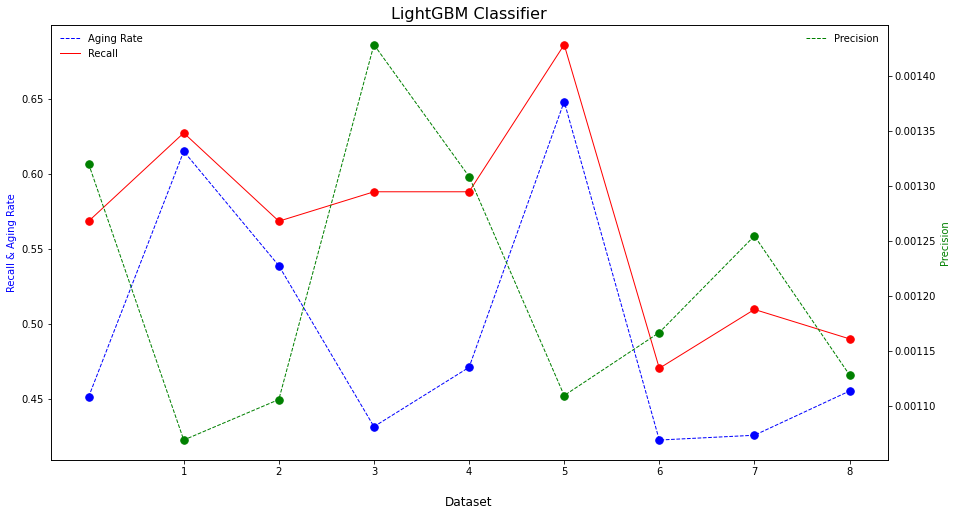

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,29.0,21937.0,22.0,26661.0,0.001320,0.568627,0.451520,1.259363,0.001317,0.463478
dataset2,1.000000,2997.0,2997.0,32.0,29897.0,19.0,18701.0,0.001069,0.627451,0.615203,1.019909,0.001067,0.441131
dataset3,1.000000,3038.0,3038.0,29.0,26191.0,22.0,22407.0,0.001106,0.568627,0.538963,1.055040,0.001104,0.409580
dataset4,1.000000,3038.0,3038.0,30.0,20971.0,21.0,27627.0,0.001429,0.588235,0.431684,1.362652,0.001425,0.505756
dataset5,1.006623,3040.0,3020.0,30.0,22894.0,21.0,25704.0,0.001309,0.588235,0.471212,1.248345,0.001306,0.476585
dataset6,1.013333,3040.0,3000.0,35.0,31507.0,16.0,17091.0,0.001110,0.686275,0.648359,1.058480,0.001108,0.495468
dataset7,1.000000,3040.0,3040.0,24.0,20543.0,27.0,28055.0,0.001167,0.470588,0.422763,1.113125,0.001164,0.352079
dataset8,1.000000,3040.0,3040.0,26.0,20696.0,25.0,27902.0,0.001255,0.509804,0.425949,1.196866,0.001252,0.401232
dataset9,10.000000,3040.0,304.0,25.0,22131.0,26.0,26467.0,0.001128,0.490196,0.455426,1.076347,0.001126,0.358142


In [6]:
line_chart(table_setC, title = 'LightGBM Classifier')
table_setC

### Export

In [8]:
savedate = '20220405'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'LightGBM'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'LightGBM')